In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import Transformer 
from tqdm import tqdm
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [19]:
import importlib

importlib.reload(Transformer)

output_dim = 2  # To begin with we can use a Gaussian with mean and variance
d_model = 1
num_heads = 1
num_layers = 2
d_ff = 512
max_seq_length = 100
dropout = 0.1

transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
)


# print(transformer(y_train[0:2])[:, :, 0])
# print(transformer(y_train[0].unsqueeze(0))[:, :, 1])
# print(transformer.generate_mask(y_train[0].unsqueeze(0)))
# prediction = transformer.generate(times[0].unsqueeze(0), 10)
# plt.plot(prediction.squeeze().detach().numpy())

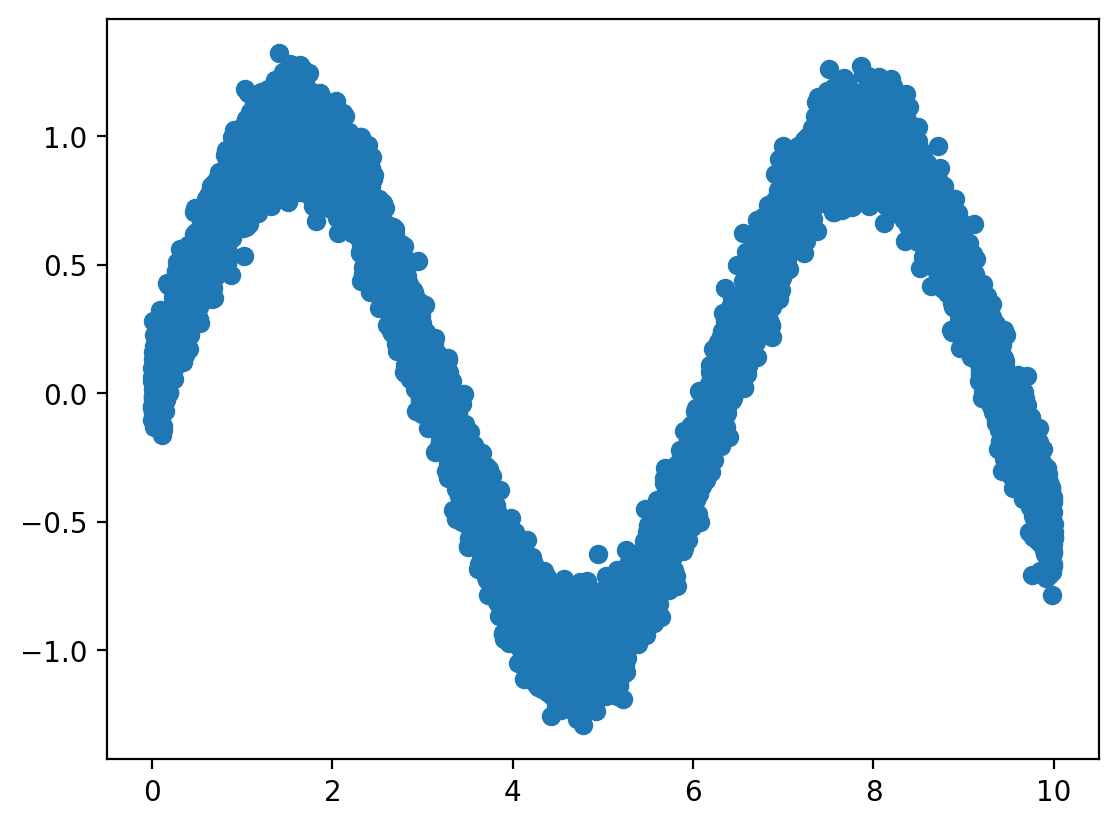

In [20]:
# Ok lets generate some fake time series data
n_data = 10_000
t = np.linspace(0, 10, n_data)
y1 = np.sin(t) + np.random.normal(0, 0.1, n_data)

# Lets plot it
plt.scatter(t, y1)
plt.show()

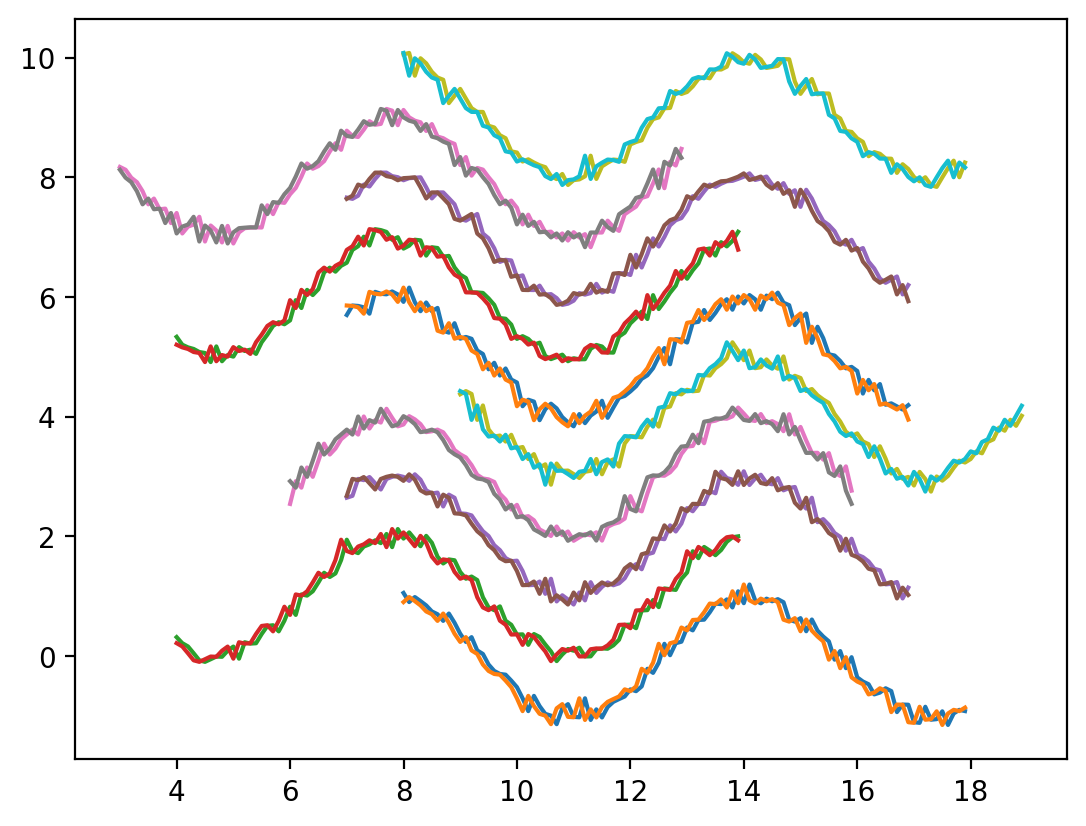

In [21]:
# We now need to package this up into random subsets of time series data
batch_size = 128


def gen_sin_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,))
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 10, max_seq_length + 1
            )
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            torch.sin(batch_time) + torch.randn(max_seq_length + 1) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


def gen_linear_training_data(batch_size):
    # Generate random start points
    start_points = torch.randint(0, 10, (batch_size,))
    batch_times = torch.stack(
        [
            torch.linspace(
                start_point.item(), start_point.item() + 10, max_seq_length + 1
            )
            for start_point in start_points
        ]
    )
    y_vals = torch.stack(
        [
            batch_time + torch.randn(max_seq_length + 1) * 0.1
            for batch_time in batch_times
        ]
    )
    # The v values for the training should be the next data point
    return (
        batch_times[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, :max_seq_length].unsqueeze(-1),
        y_vals[:, 1:],
    )


times, y_train, y_true = gen_sin_training_data(batch_size)
# times, y_train, y_true = gen_linear_training_data(batch_size)
for i in range(10):
    plt.plot(times[i], y_train[i] + i)
    plt.plot(times[i], y_true[i] + i)


plt.show()

In [22]:
# Check that the transformer can take the inputs
print(transformer(times).shape)

torch.Size([128, 100, 2])


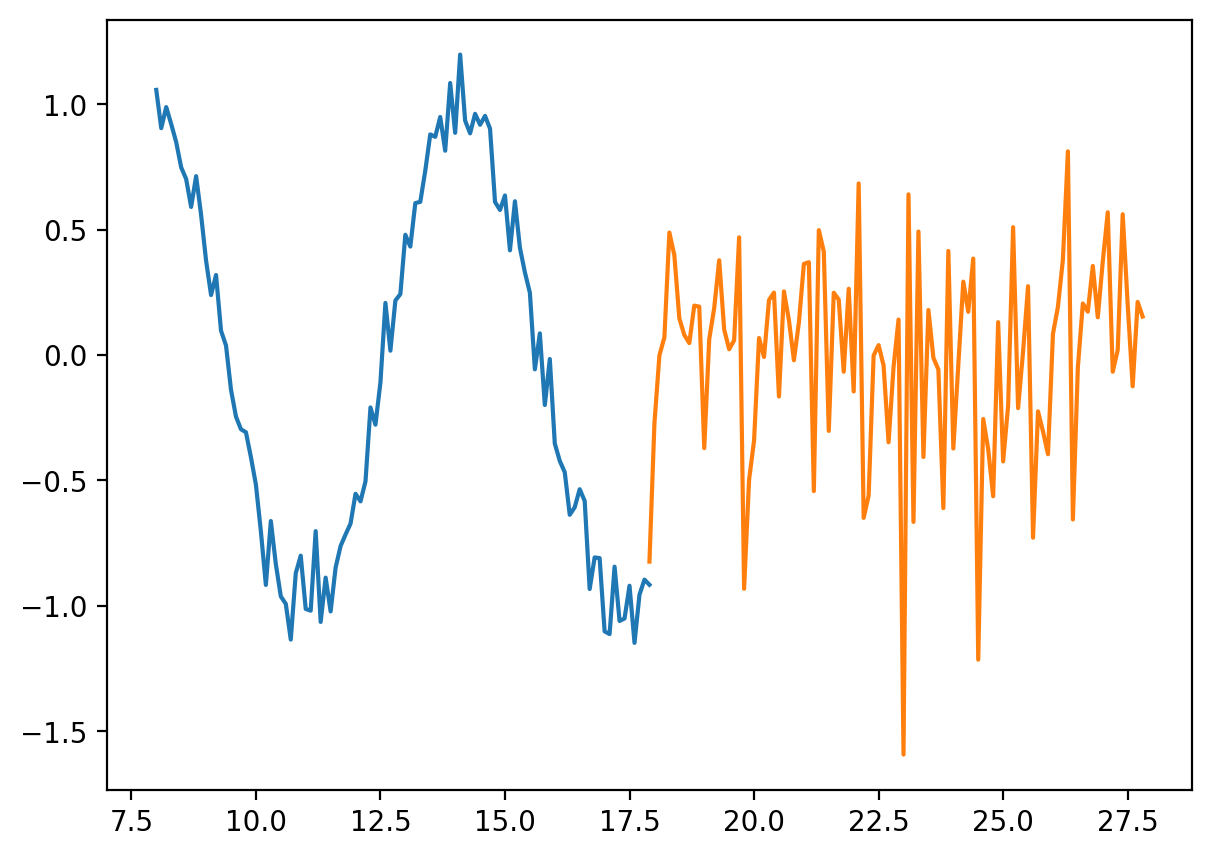

Epoch: 1, Loss: 0.726044237613678


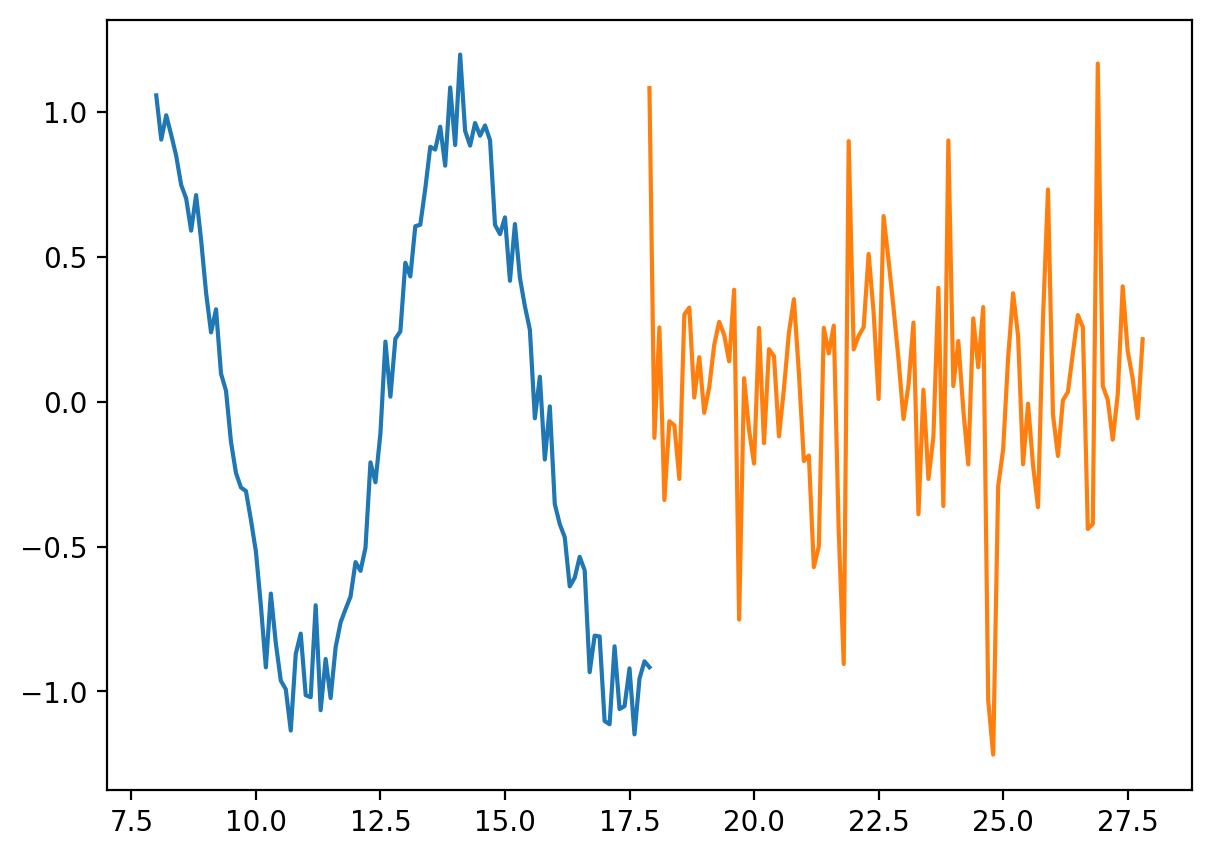

Epoch: 101, Loss: 0.6815387606620789


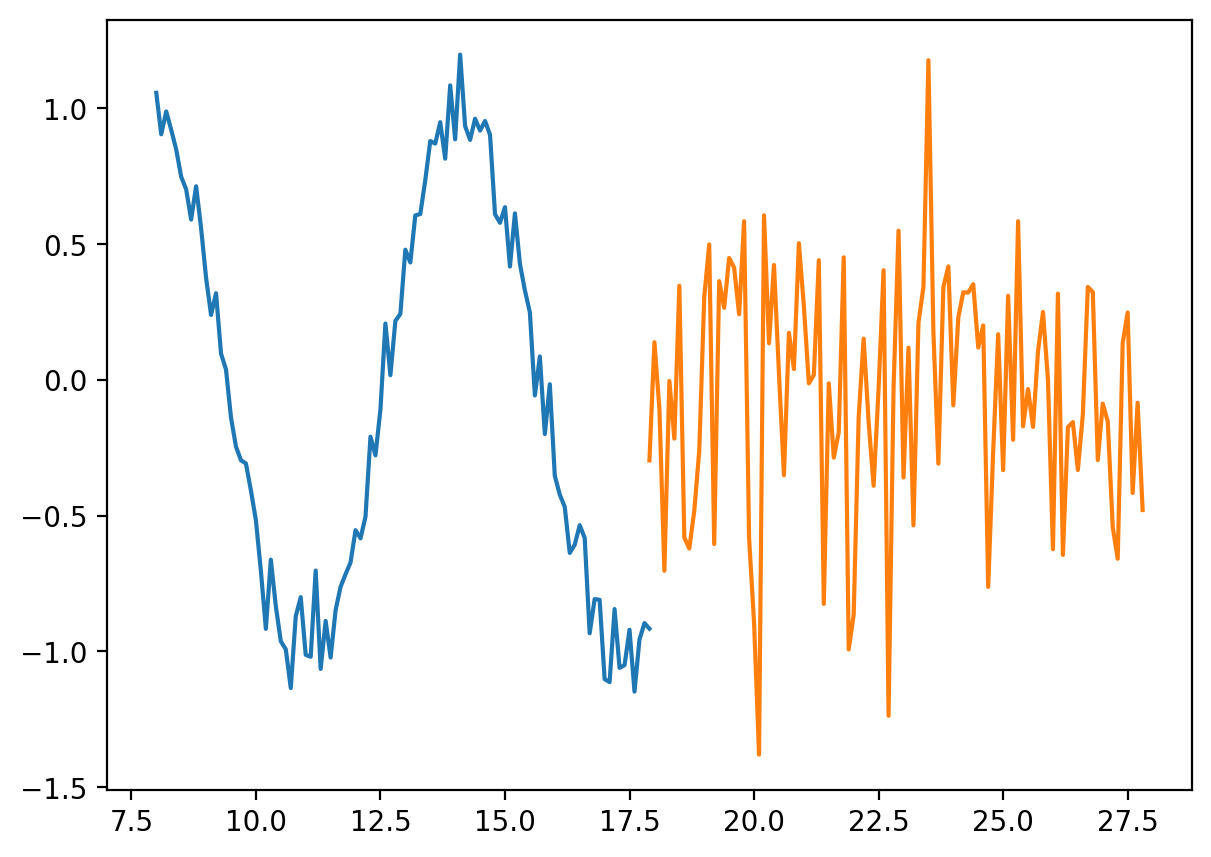

Epoch: 201, Loss: 0.6047762036323547


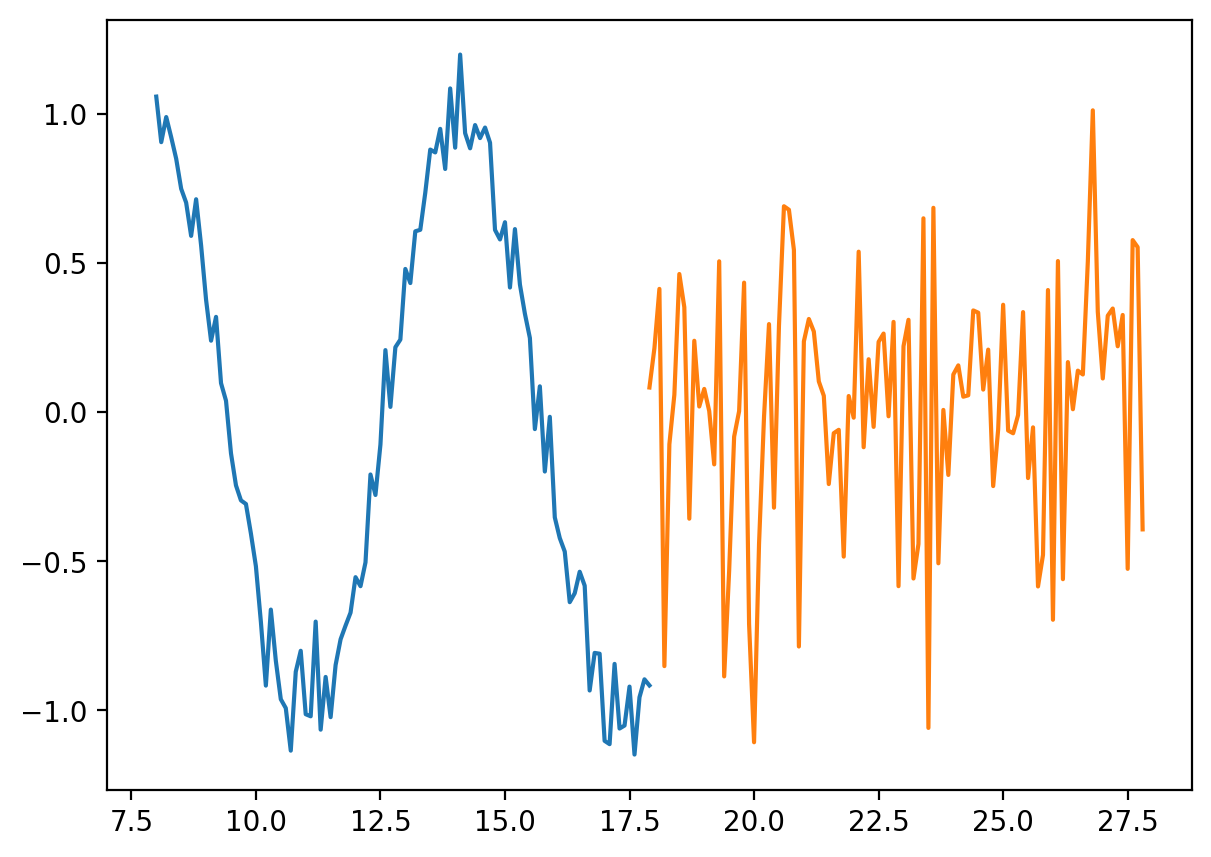

Epoch: 301, Loss: 0.48327818512916565


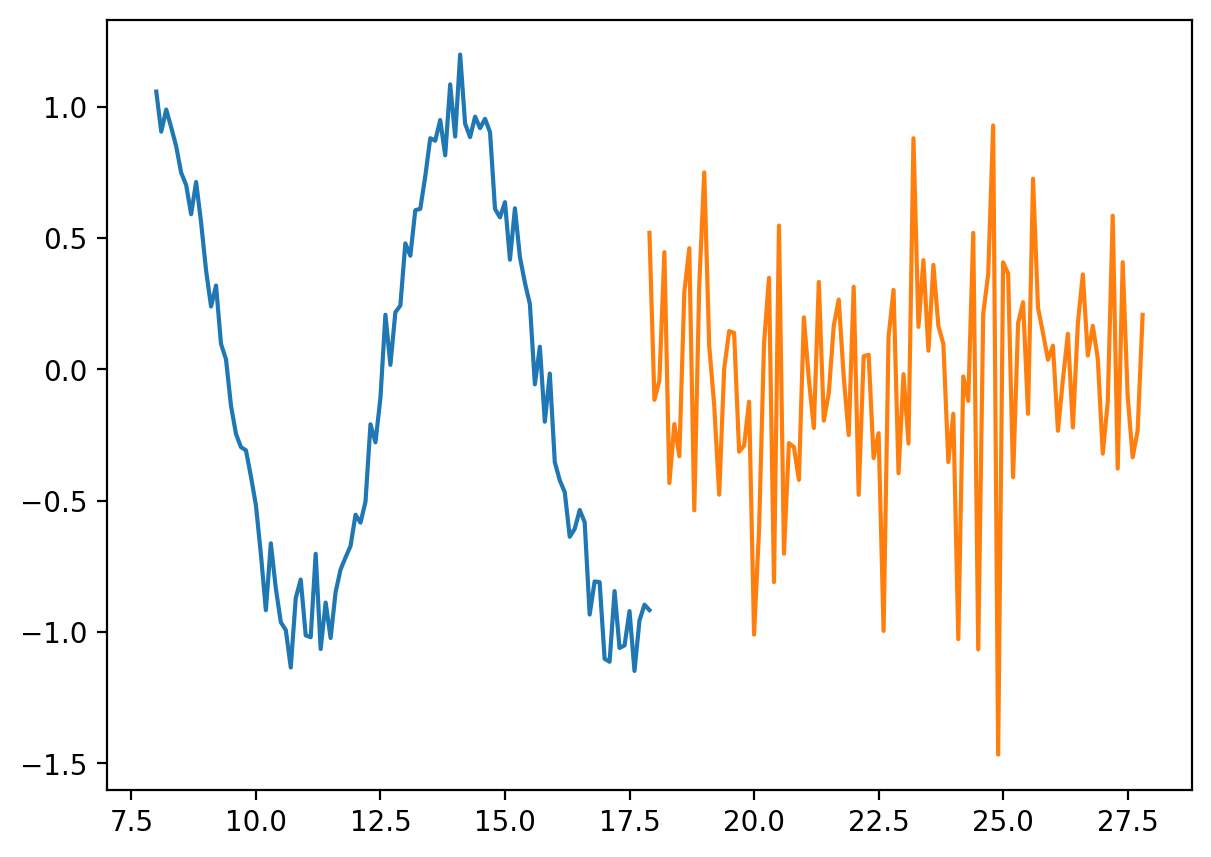

Epoch: 401, Loss: 0.7033770680427551


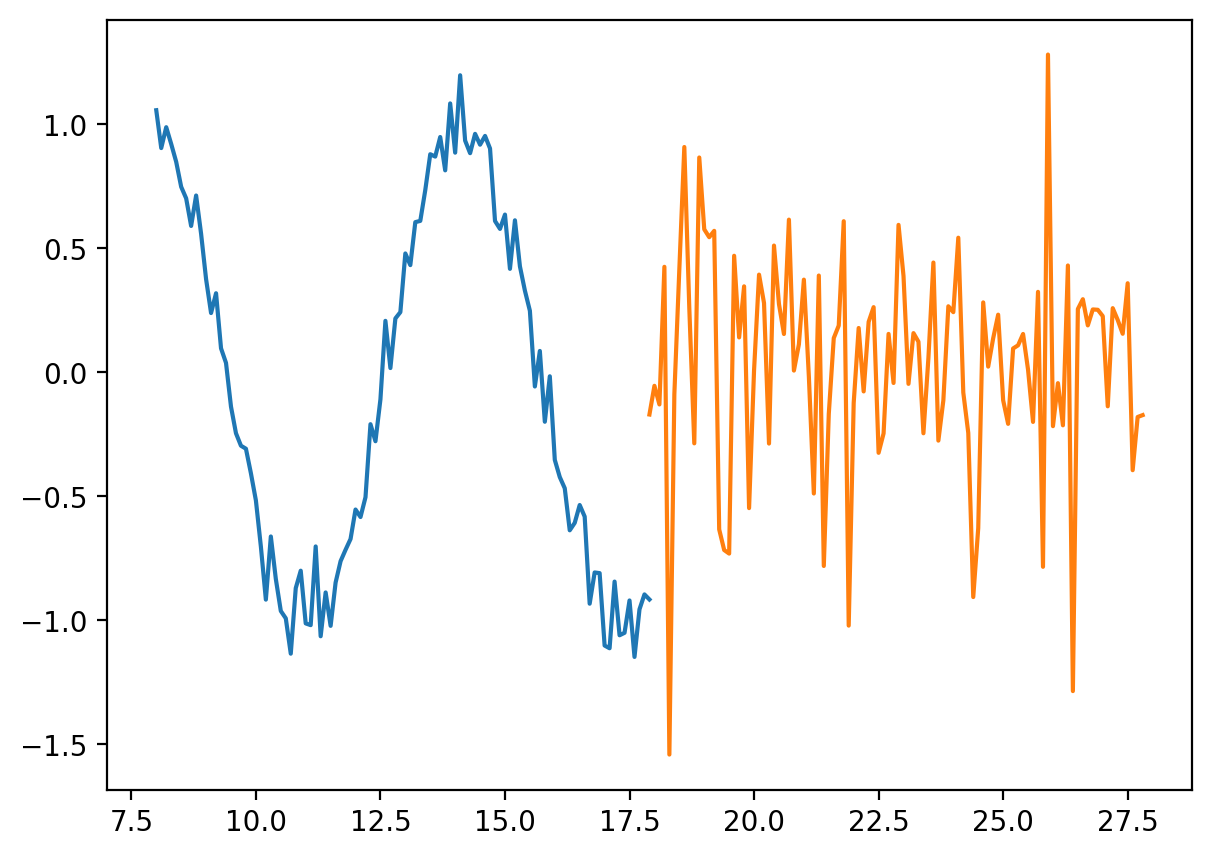

Epoch: 501, Loss: 0.6509707570075989


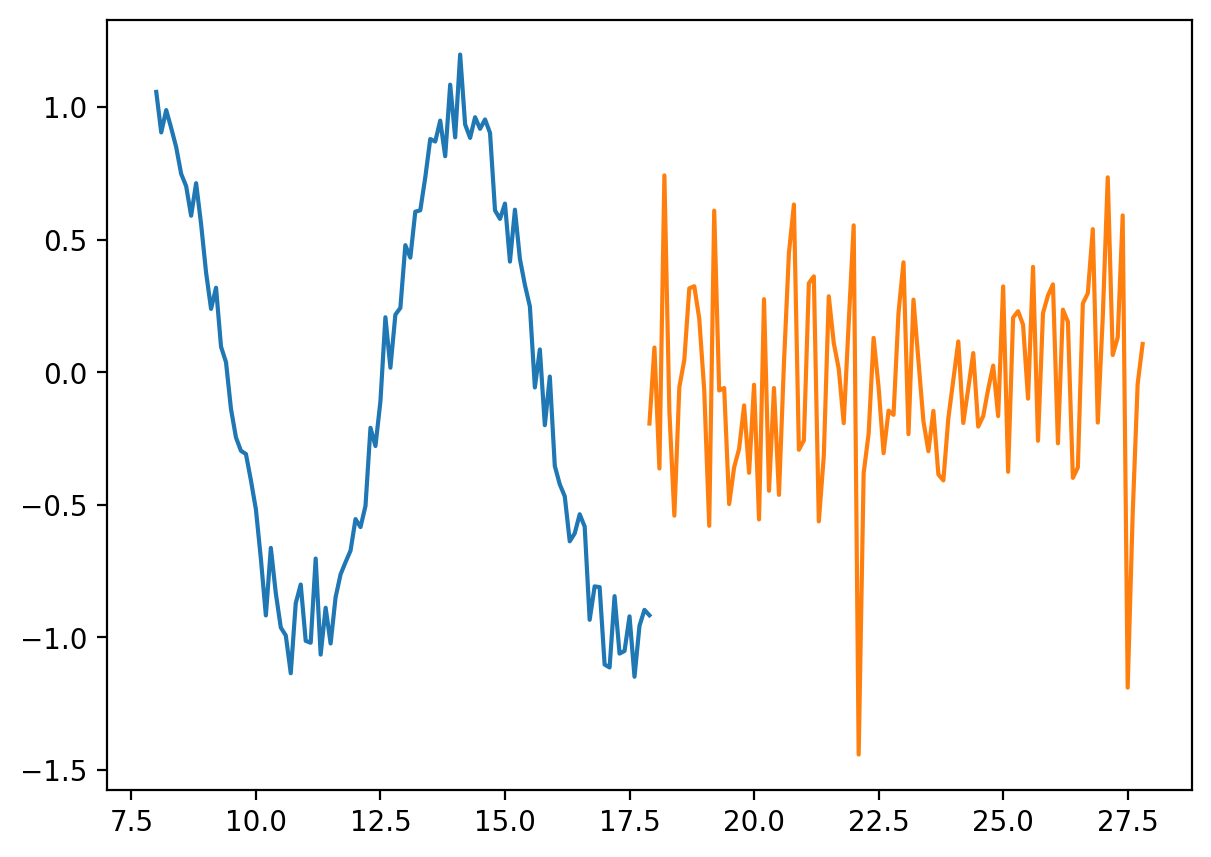

Epoch: 601, Loss: 1.6895443201065063


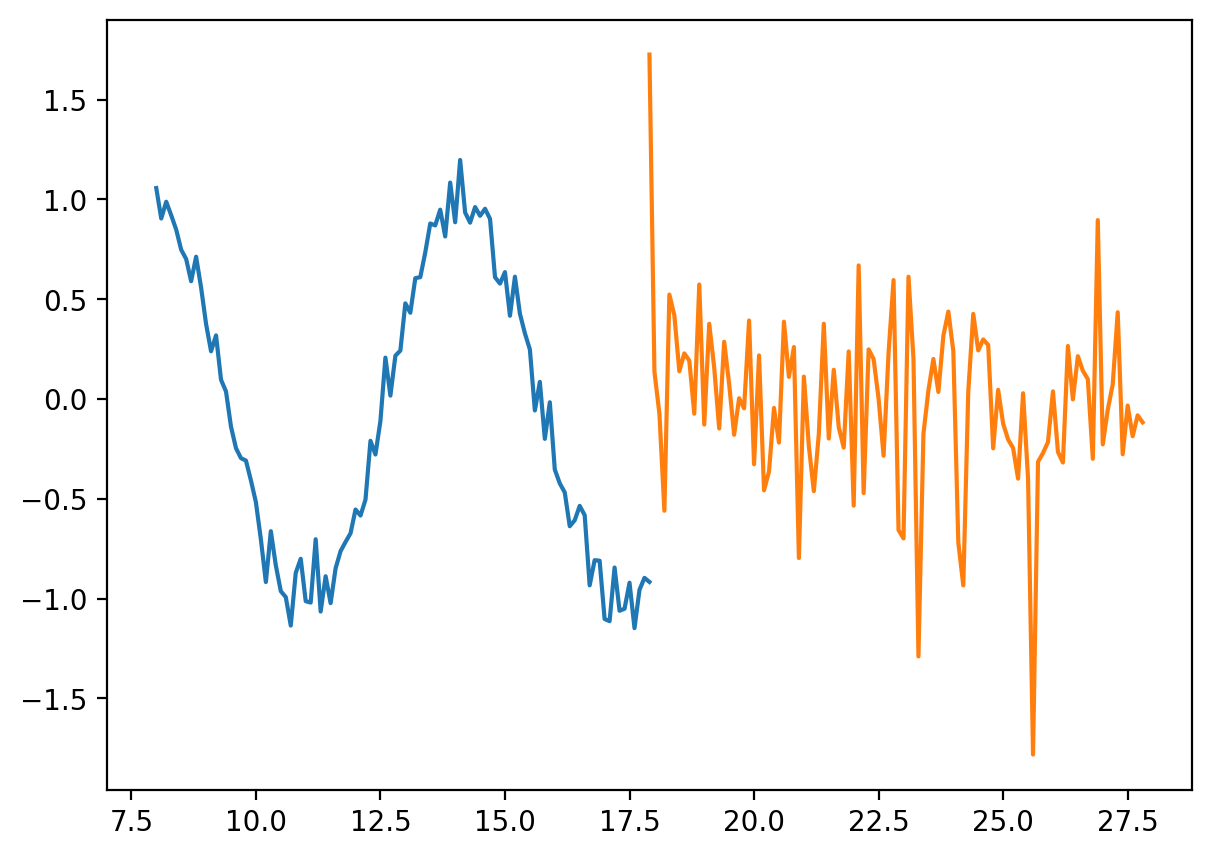

Epoch: 701, Loss: 0.5392270088195801


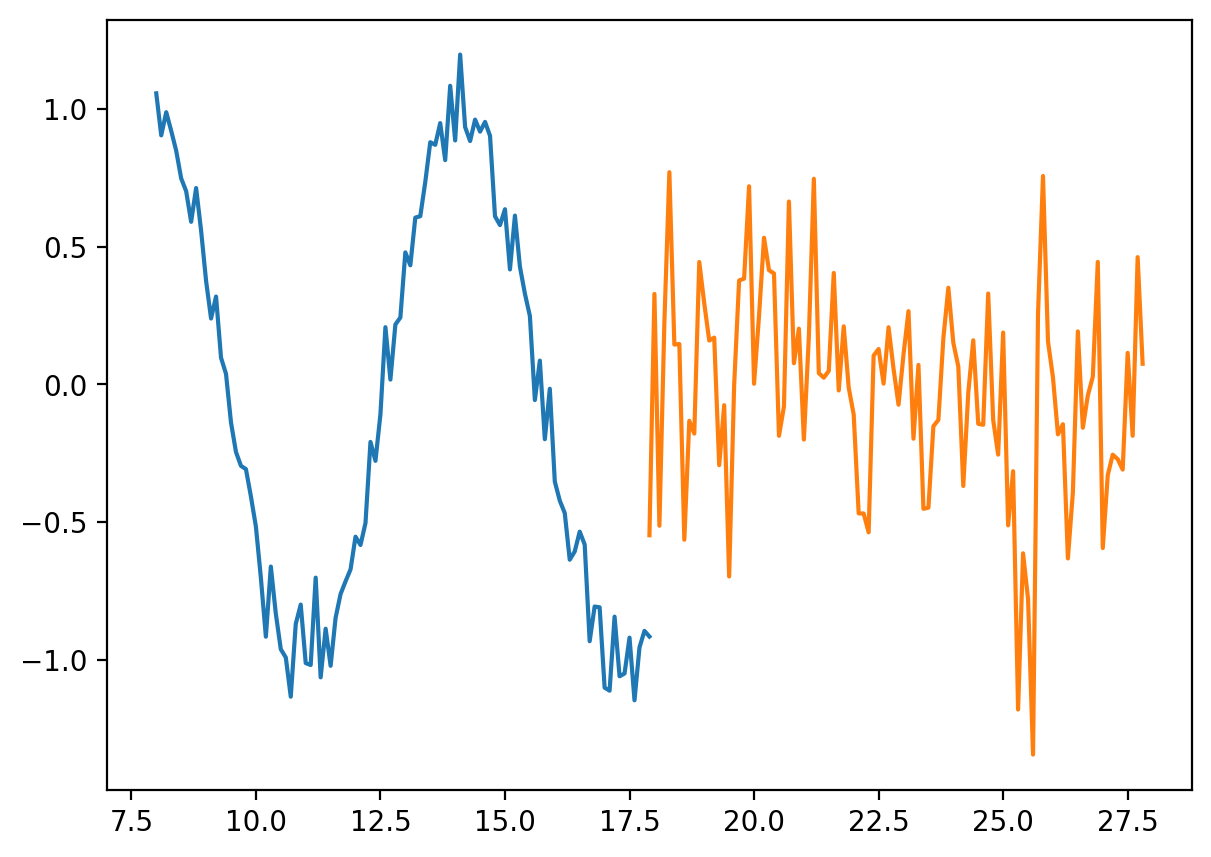

Epoch: 801, Loss: 0.5655529499053955


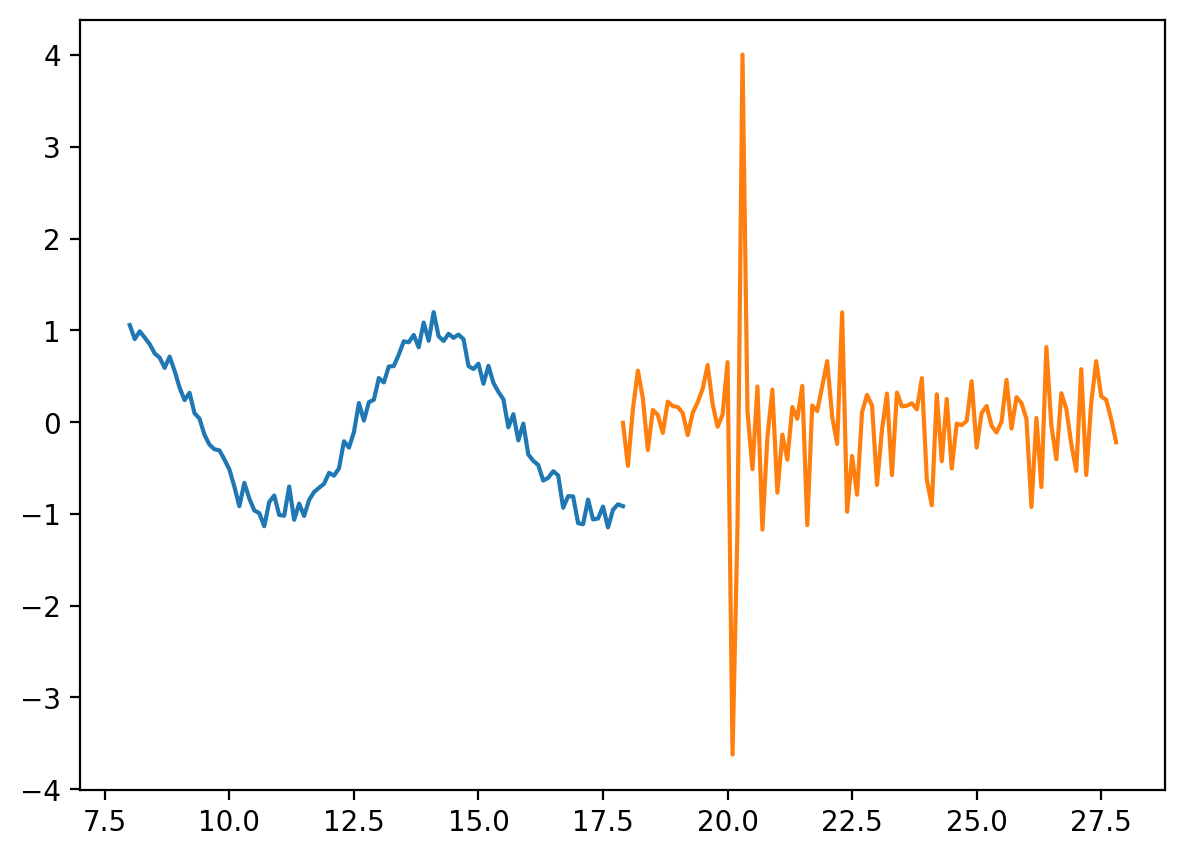

Epoch: 901, Loss: 0.6469666361808777


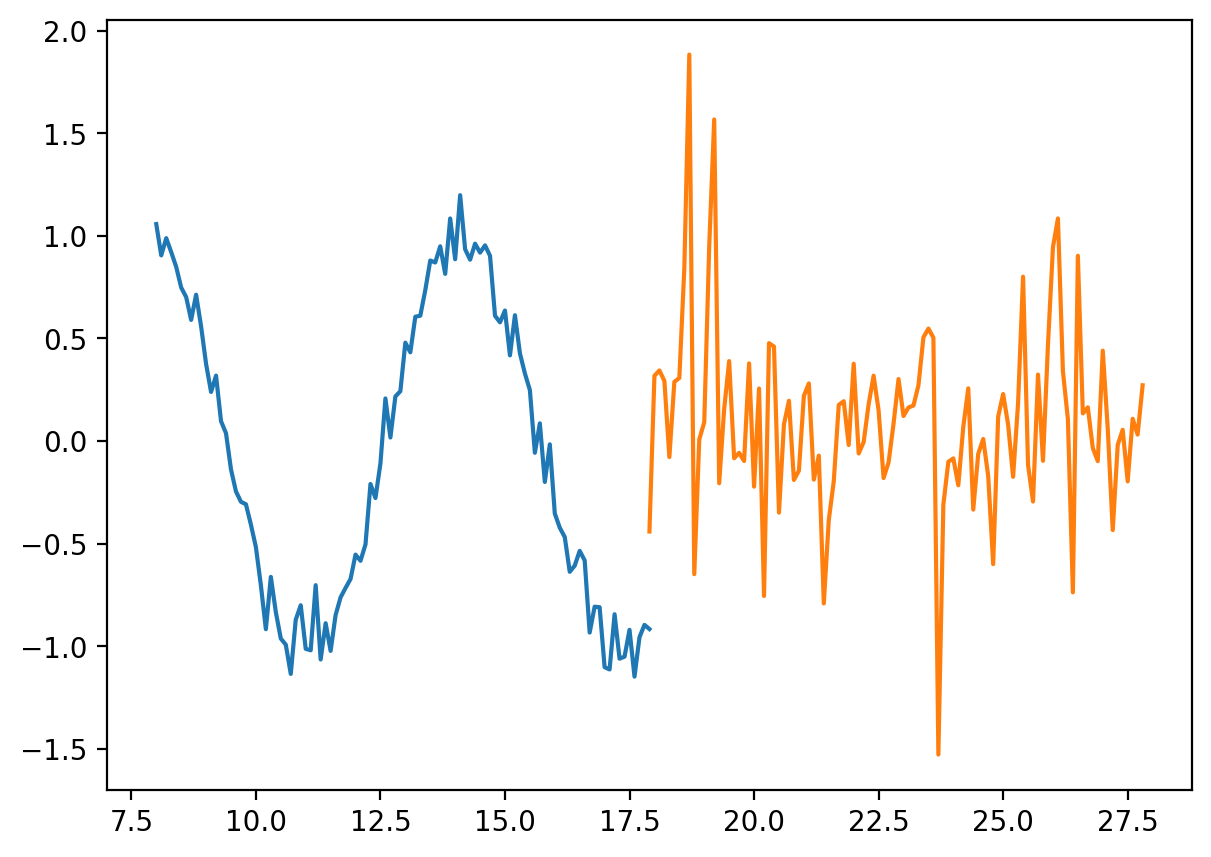

Epoch: 1001, Loss: 0.4696696400642395


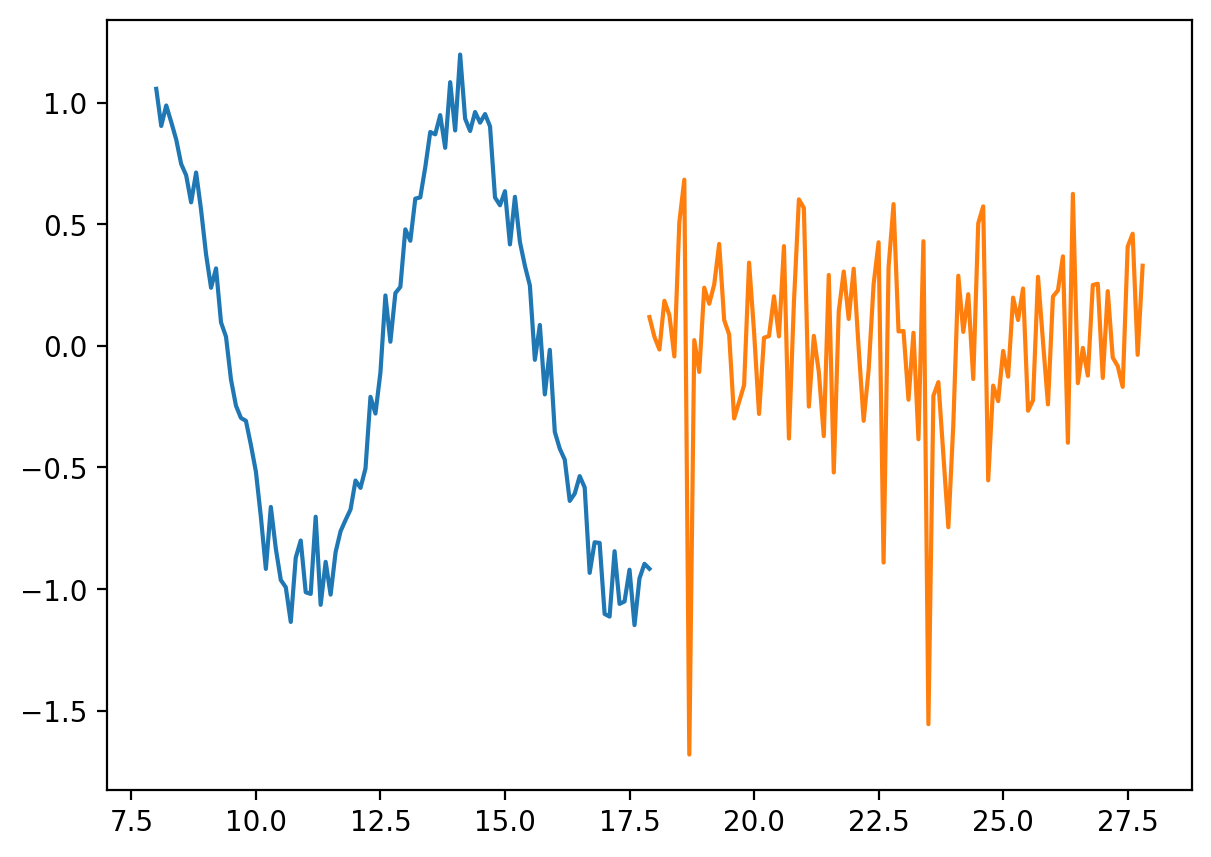

Epoch: 1101, Loss: 0.4336561858654022


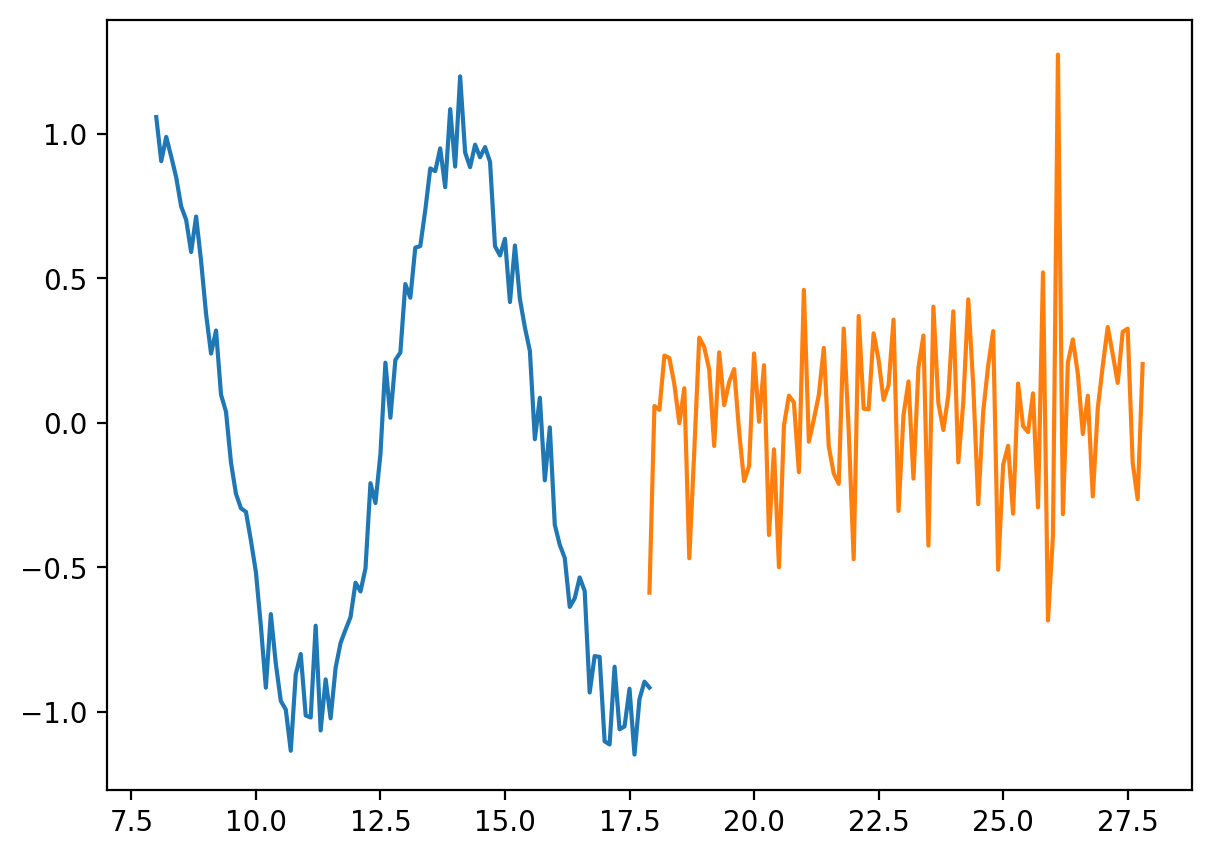

Epoch: 1201, Loss: 0.41680991649627686


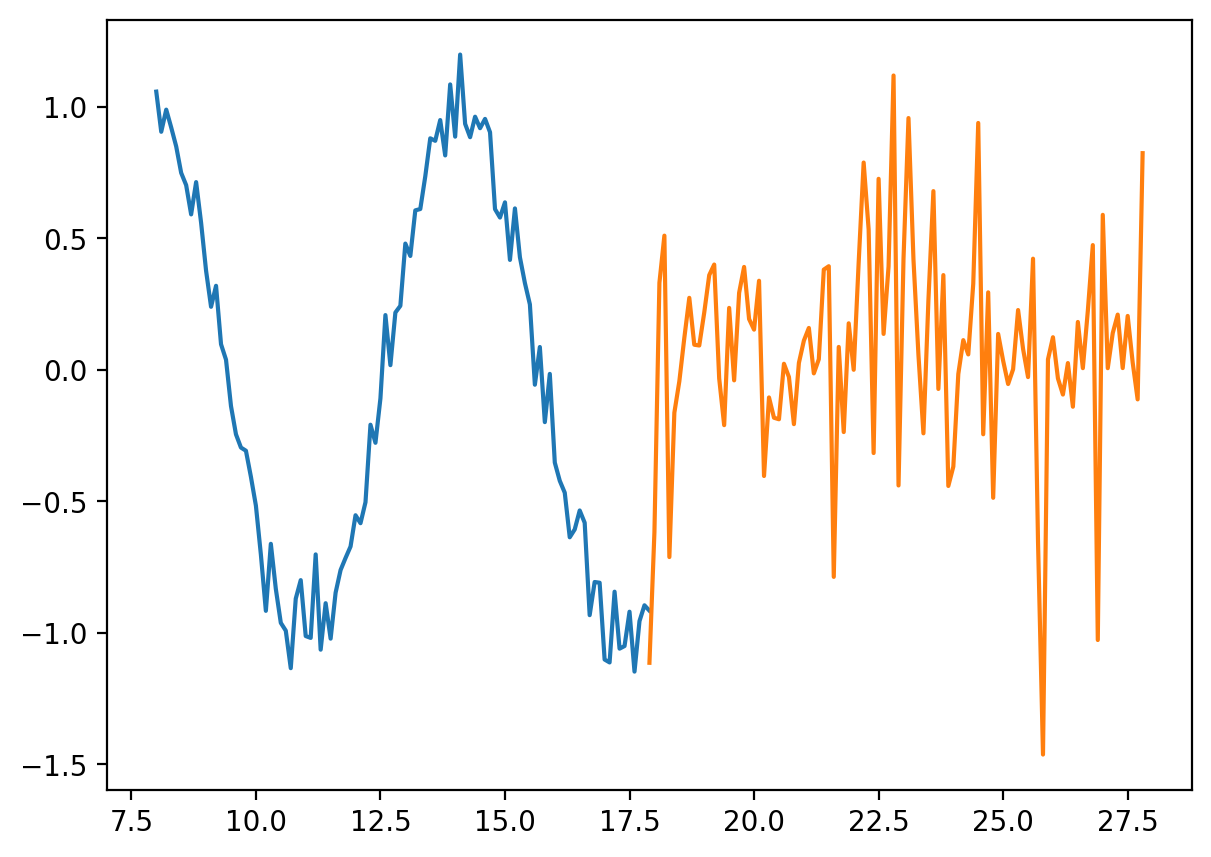

Epoch: 1301, Loss: 0.42316004633903503


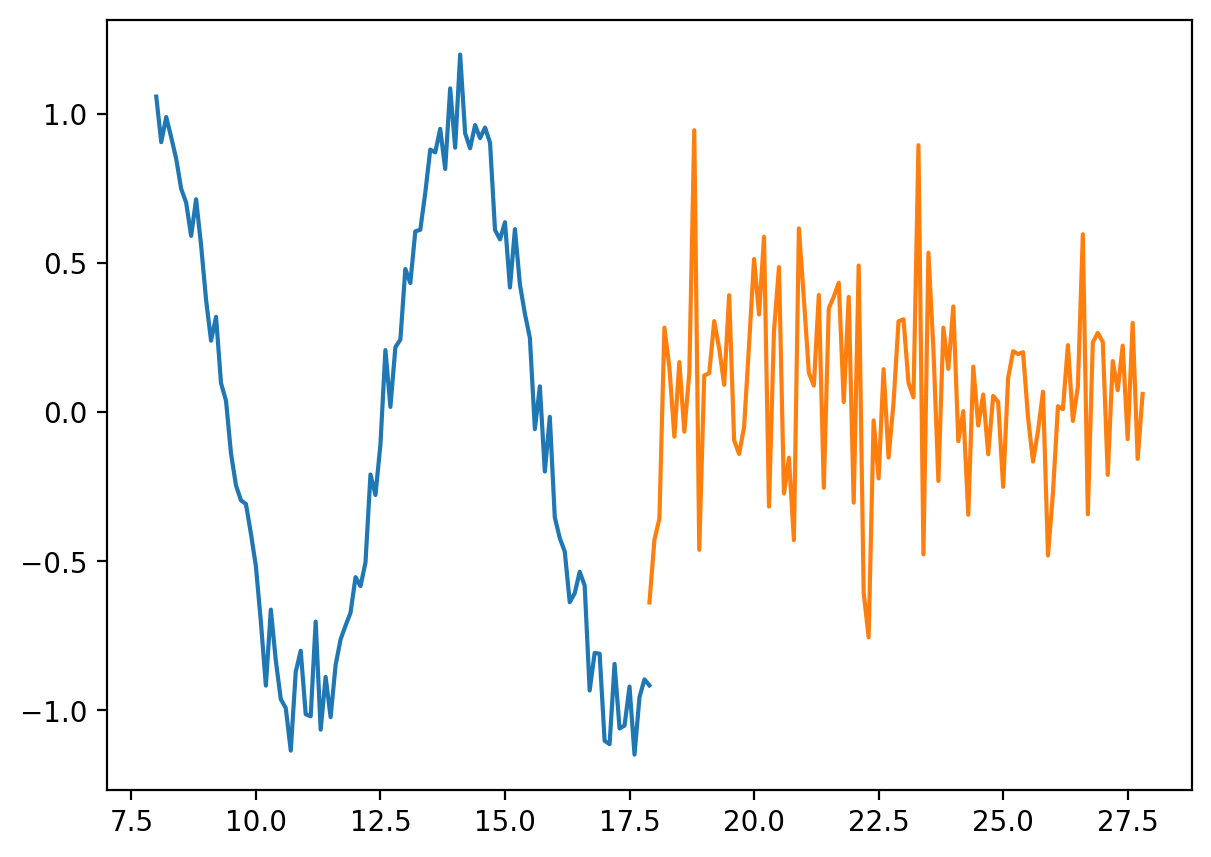

Epoch: 1401, Loss: 0.45668289065361023


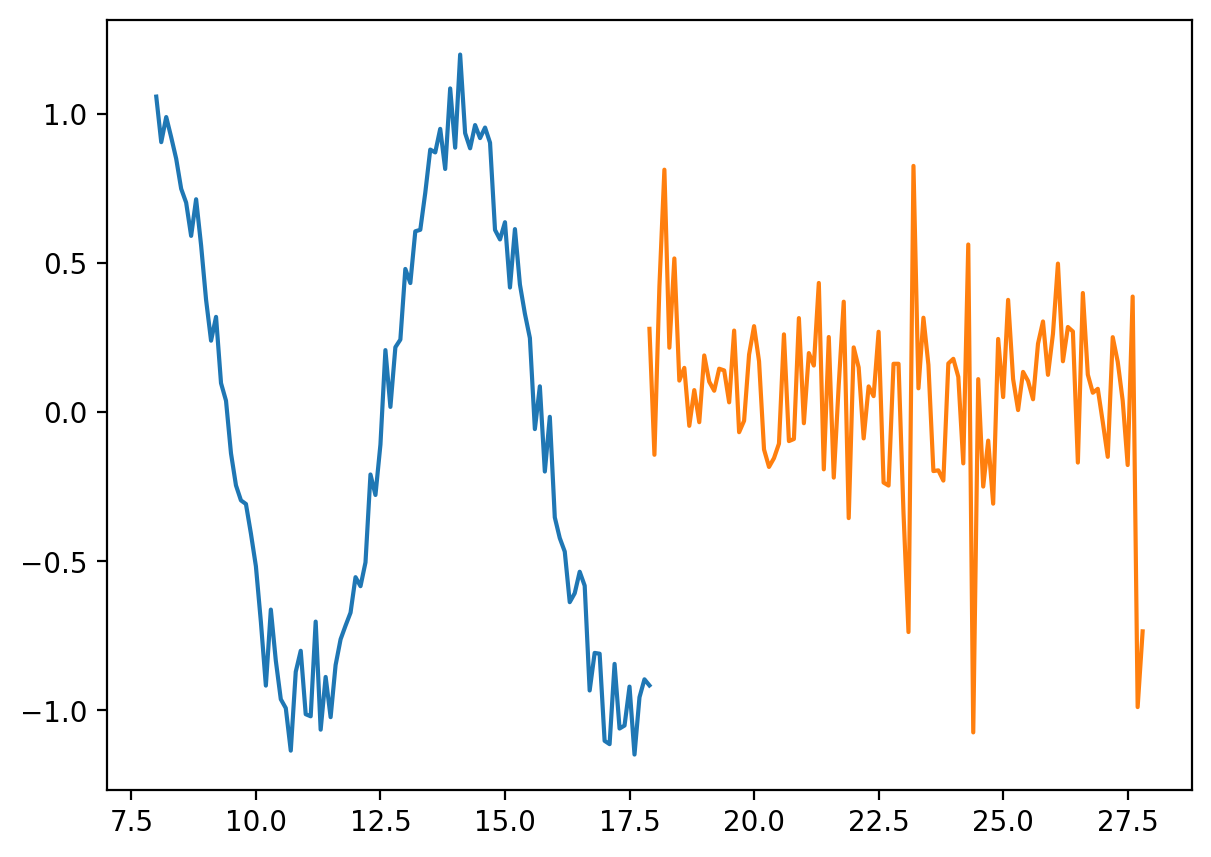

Epoch: 1501, Loss: 0.479298859834671


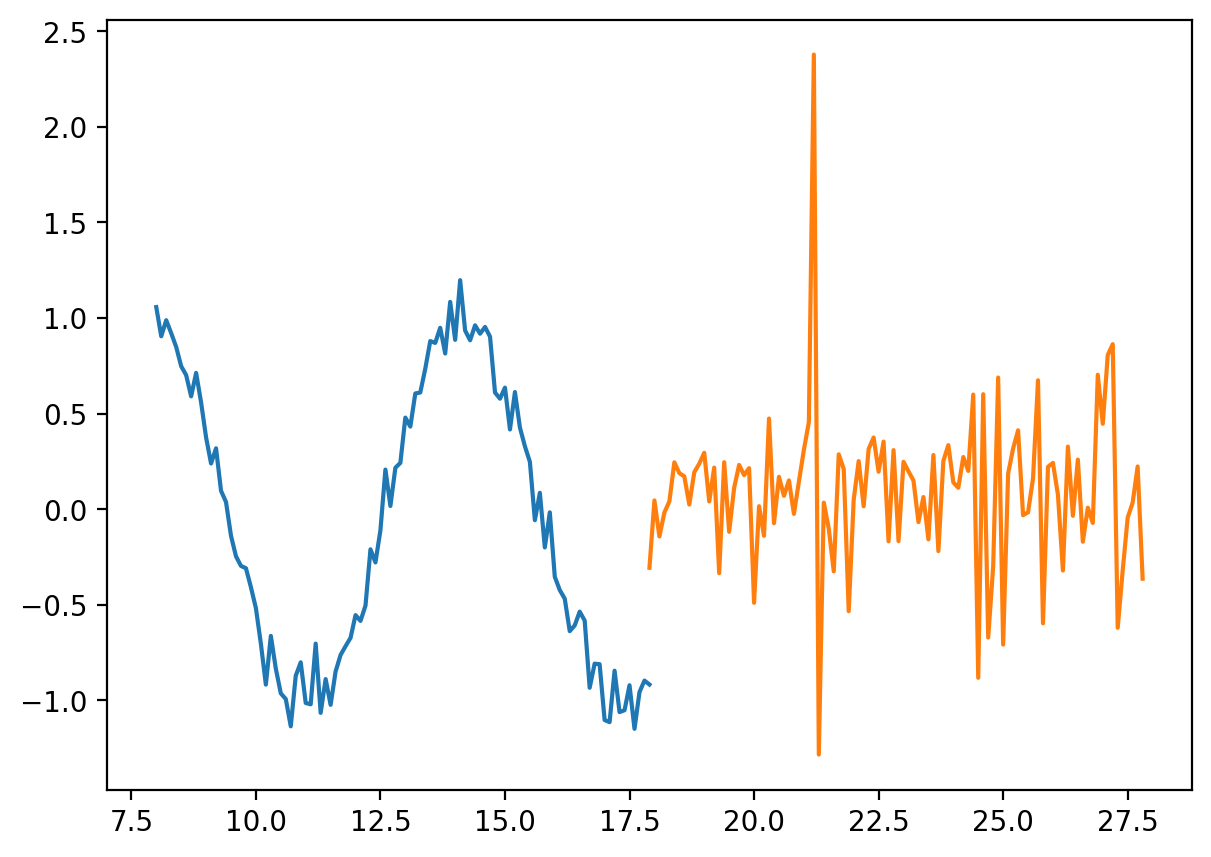

Epoch: 1601, Loss: 0.4893198013305664


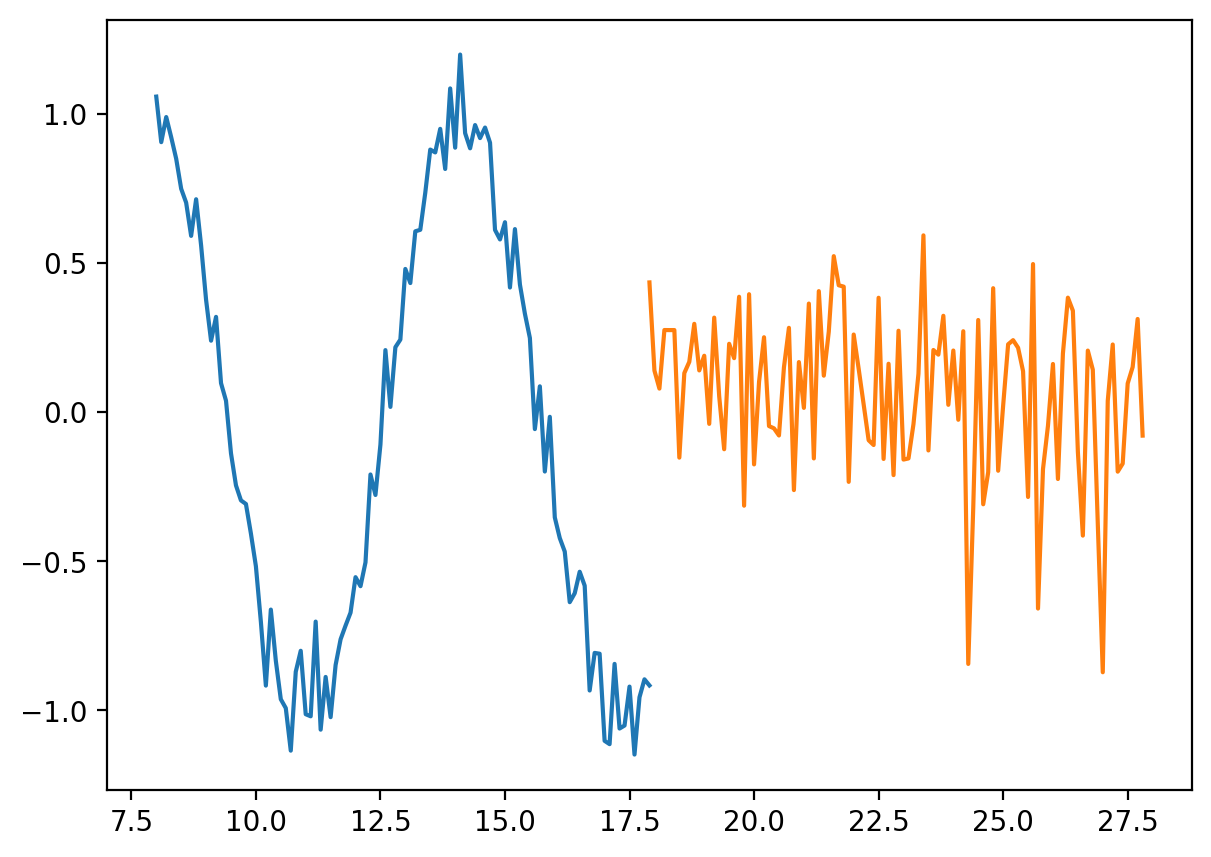

Epoch: 1701, Loss: 0.5039167404174805


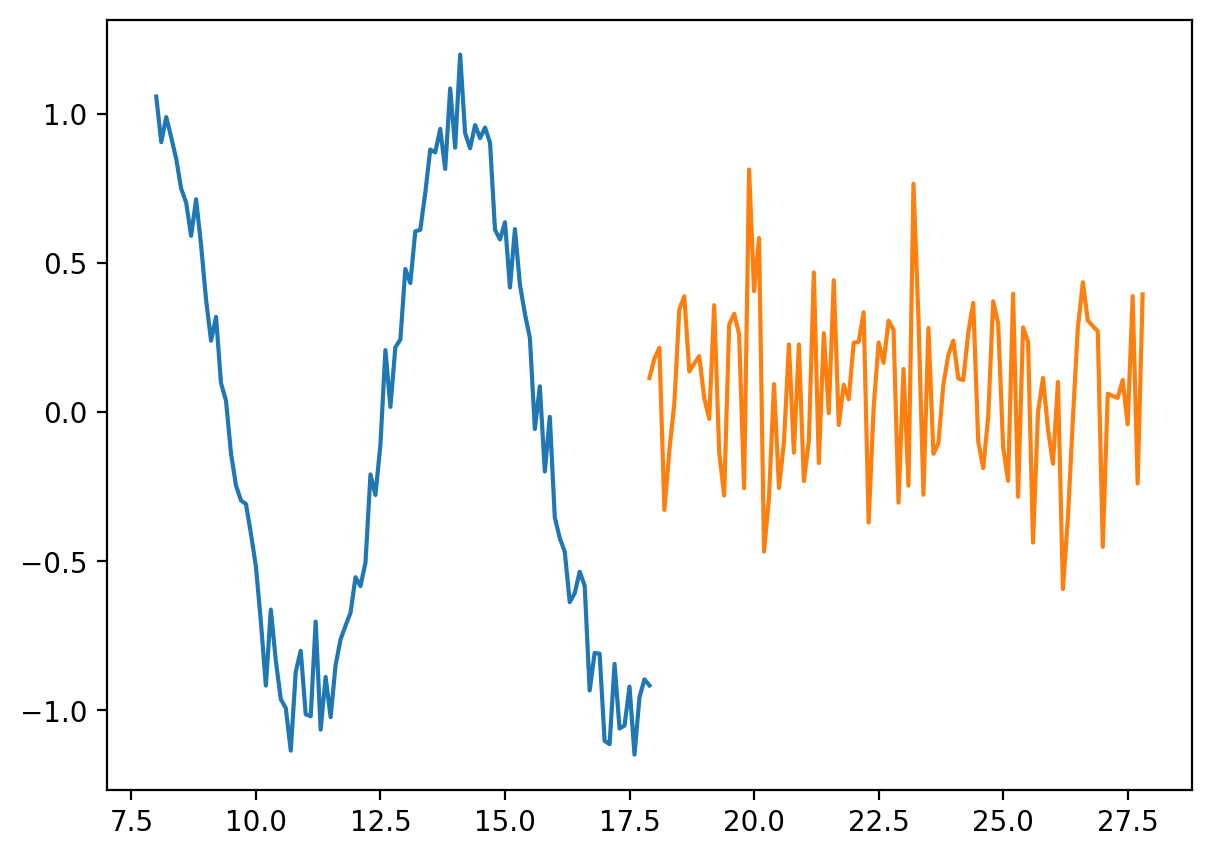

Epoch: 1801, Loss: 0.4443429112434387


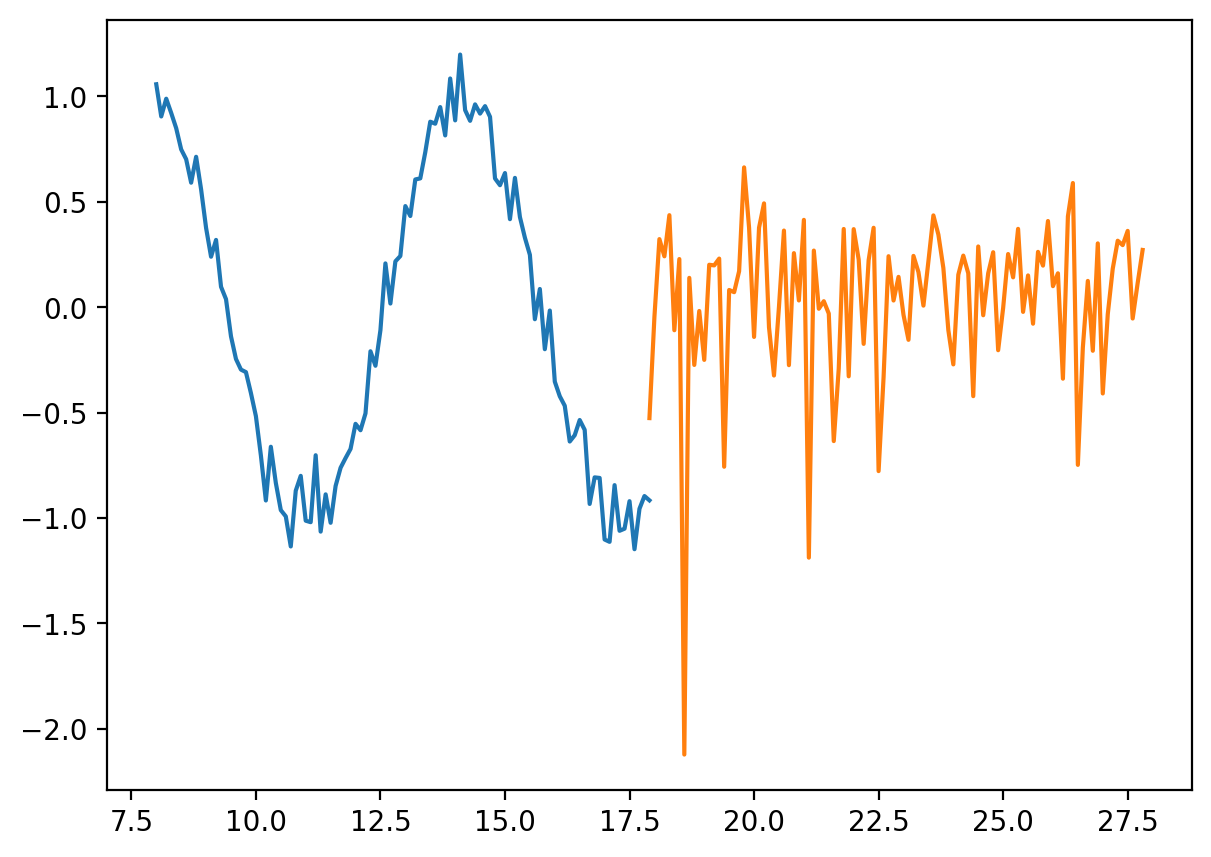

Epoch: 1901, Loss: 0.7877287268638611


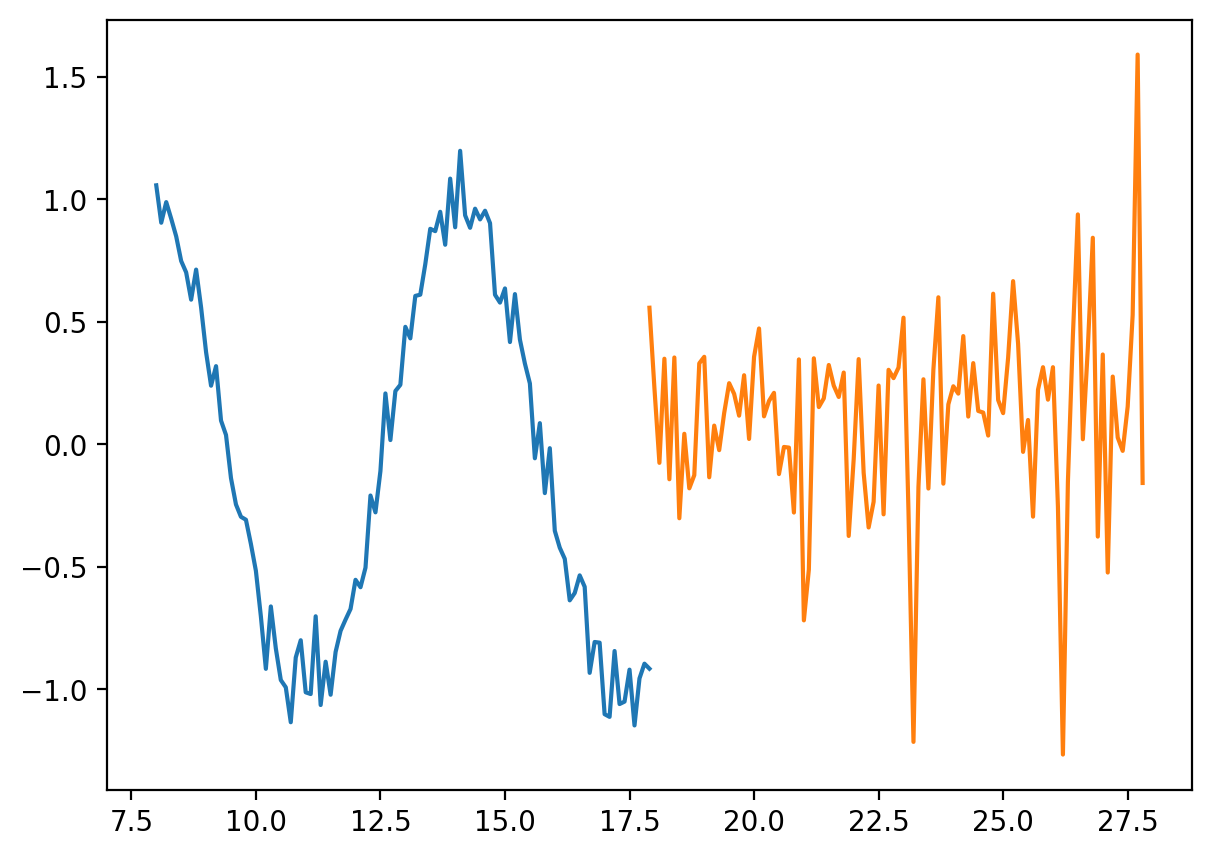

Epoch: 2001, Loss: 0.410305380821228


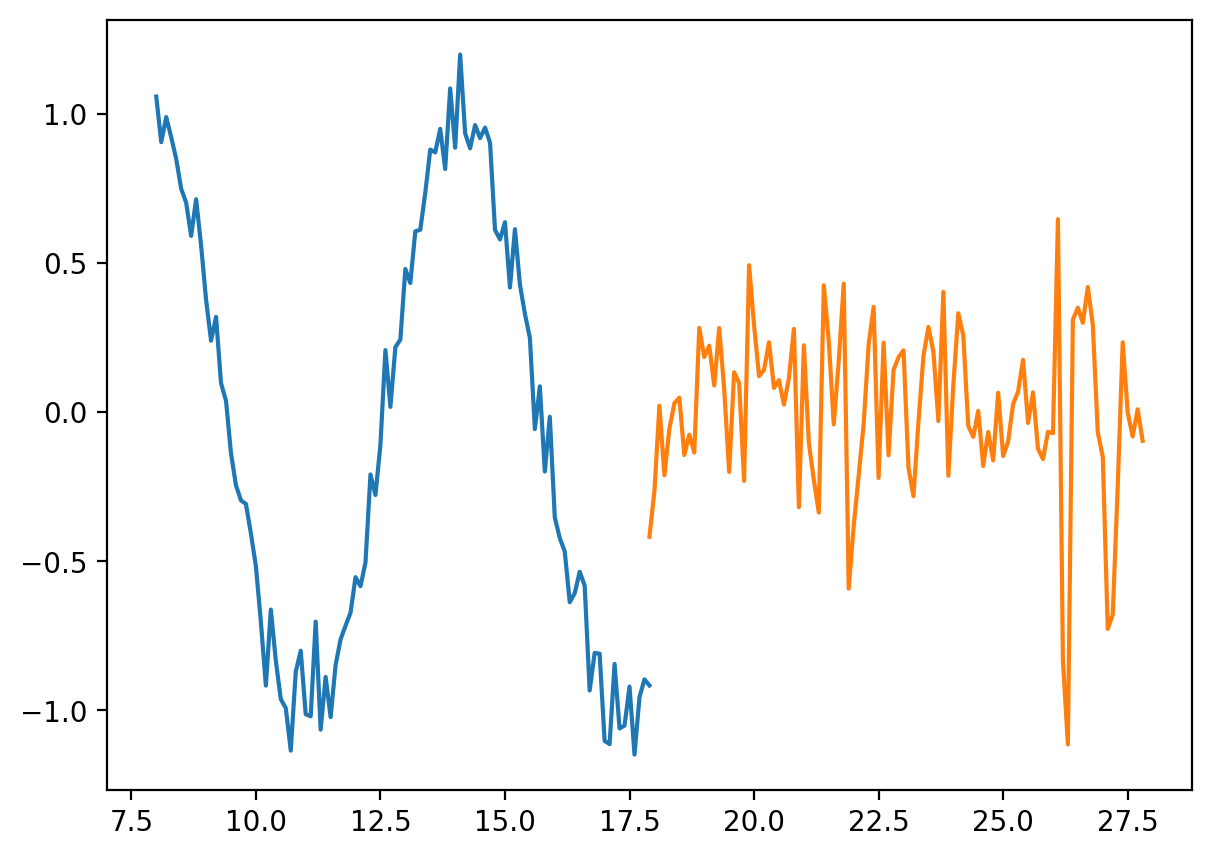

Epoch: 2101, Loss: 1.202590823173523


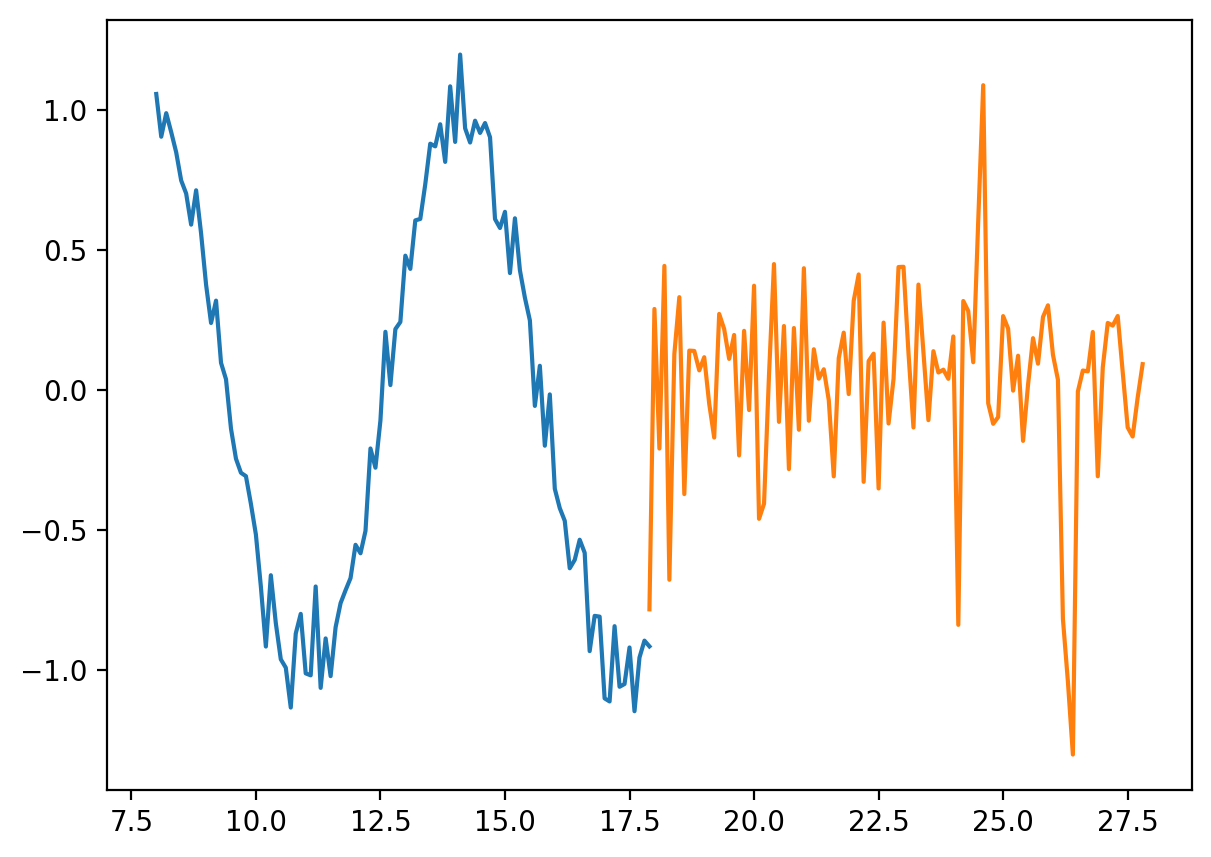

Epoch: 2201, Loss: 0.5265483260154724


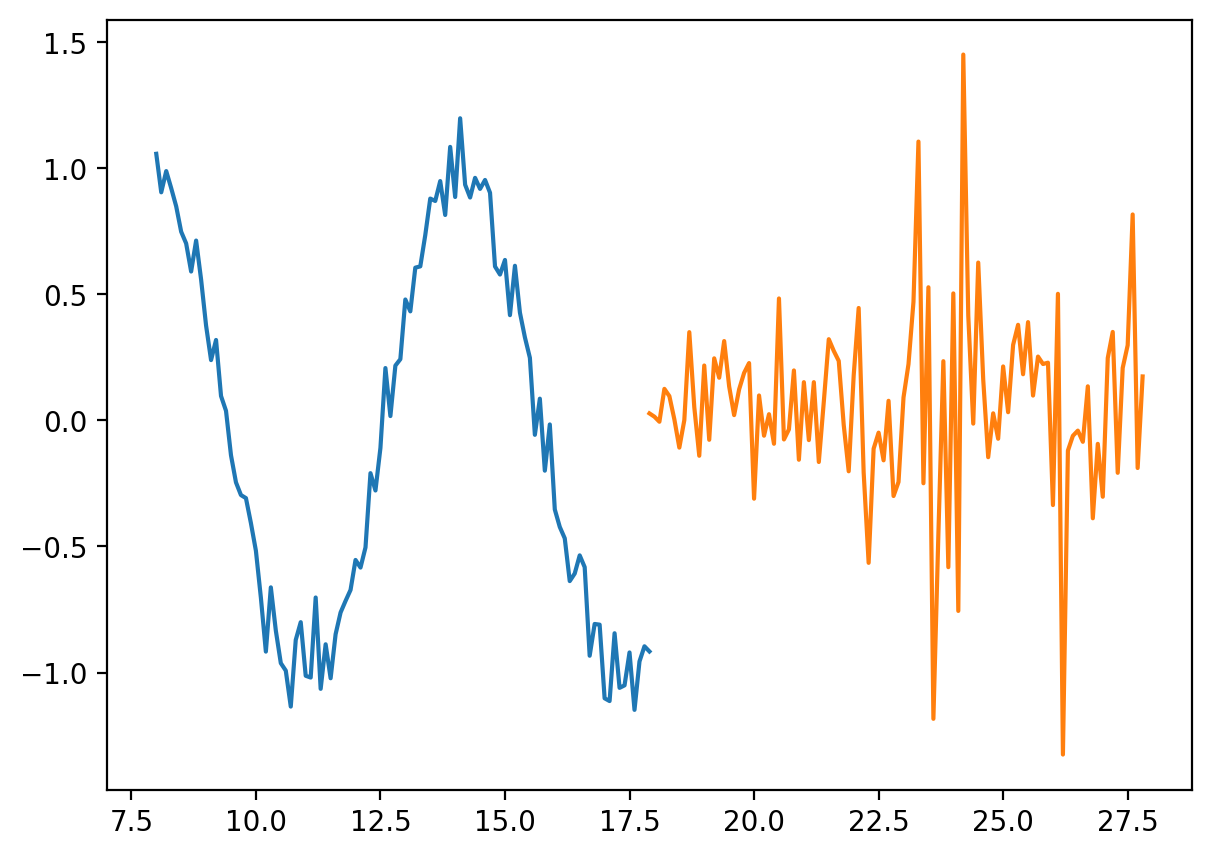

Epoch: 2301, Loss: 0.4412025213241577


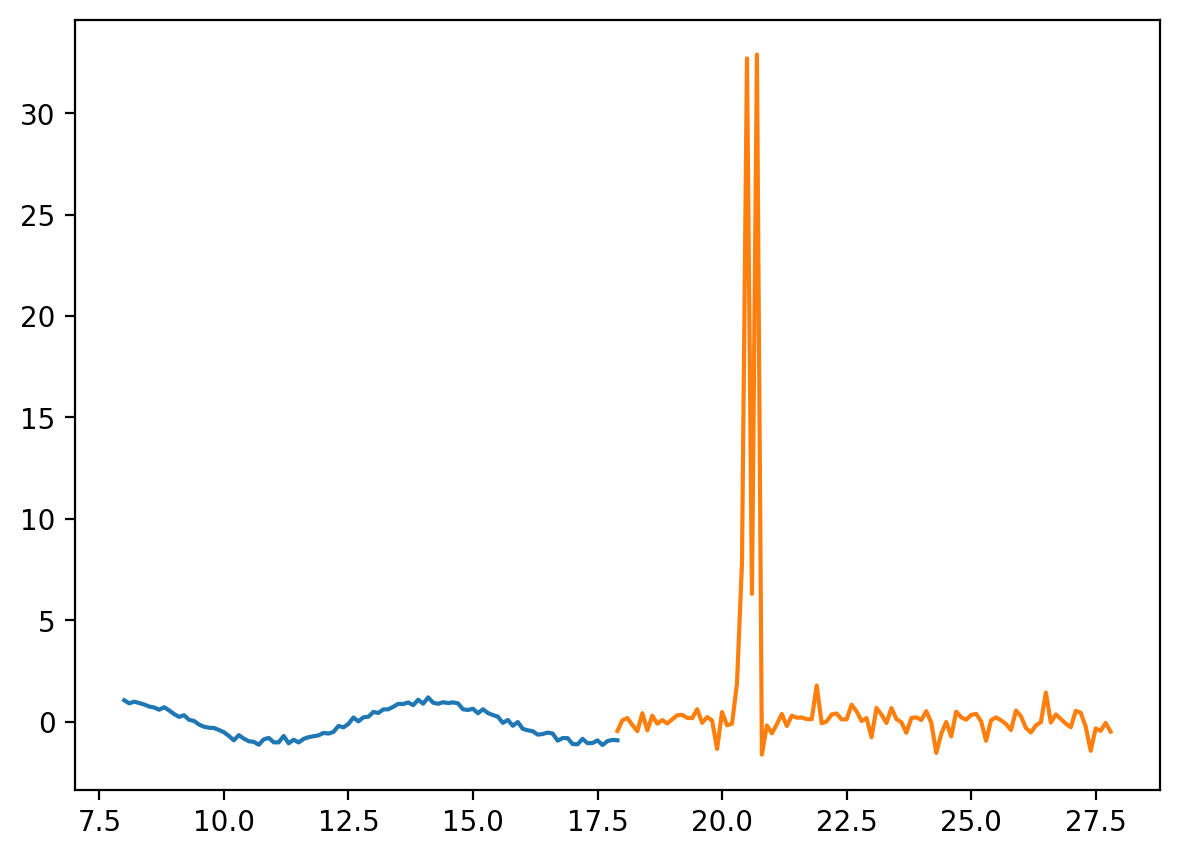

Epoch: 2401, Loss: 0.4916386306285858


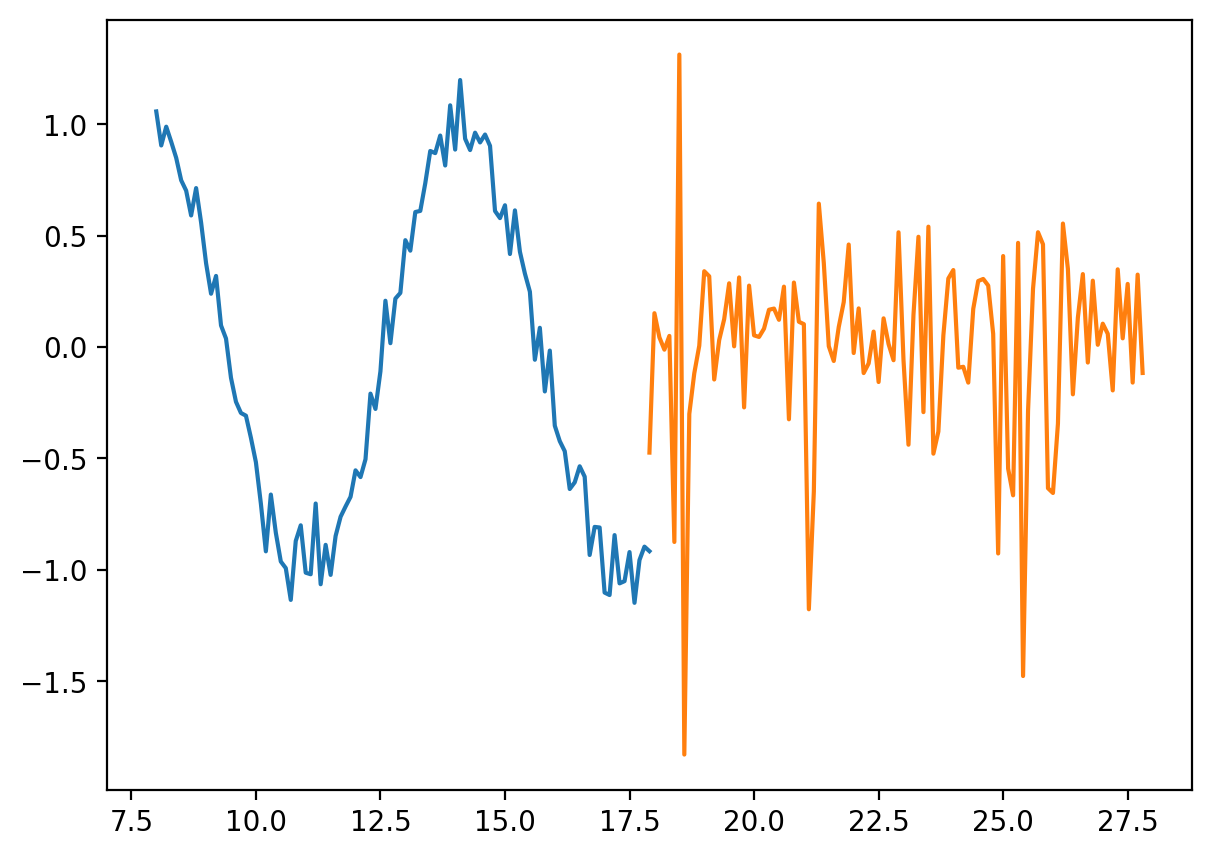

Epoch: 2501, Loss: 0.40061938762664795


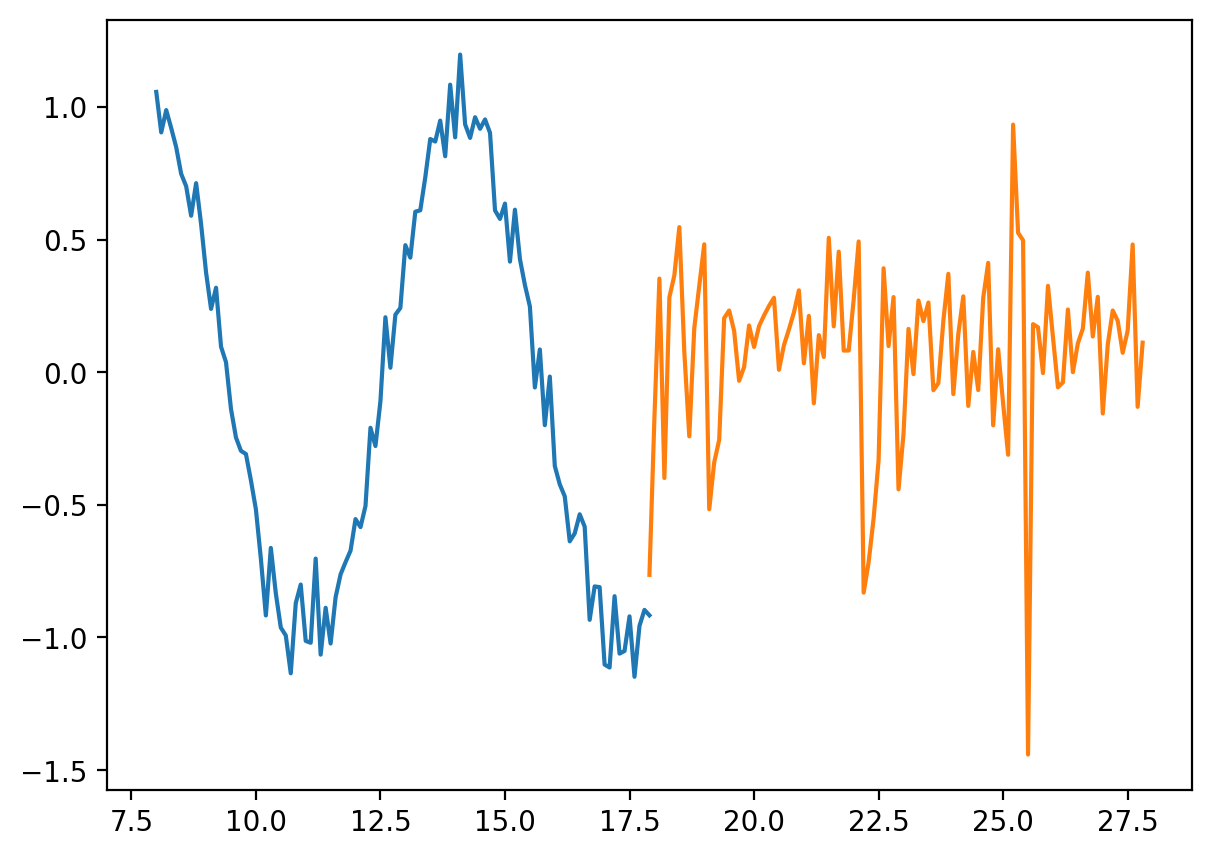

Epoch: 2601, Loss: 0.41013985872268677


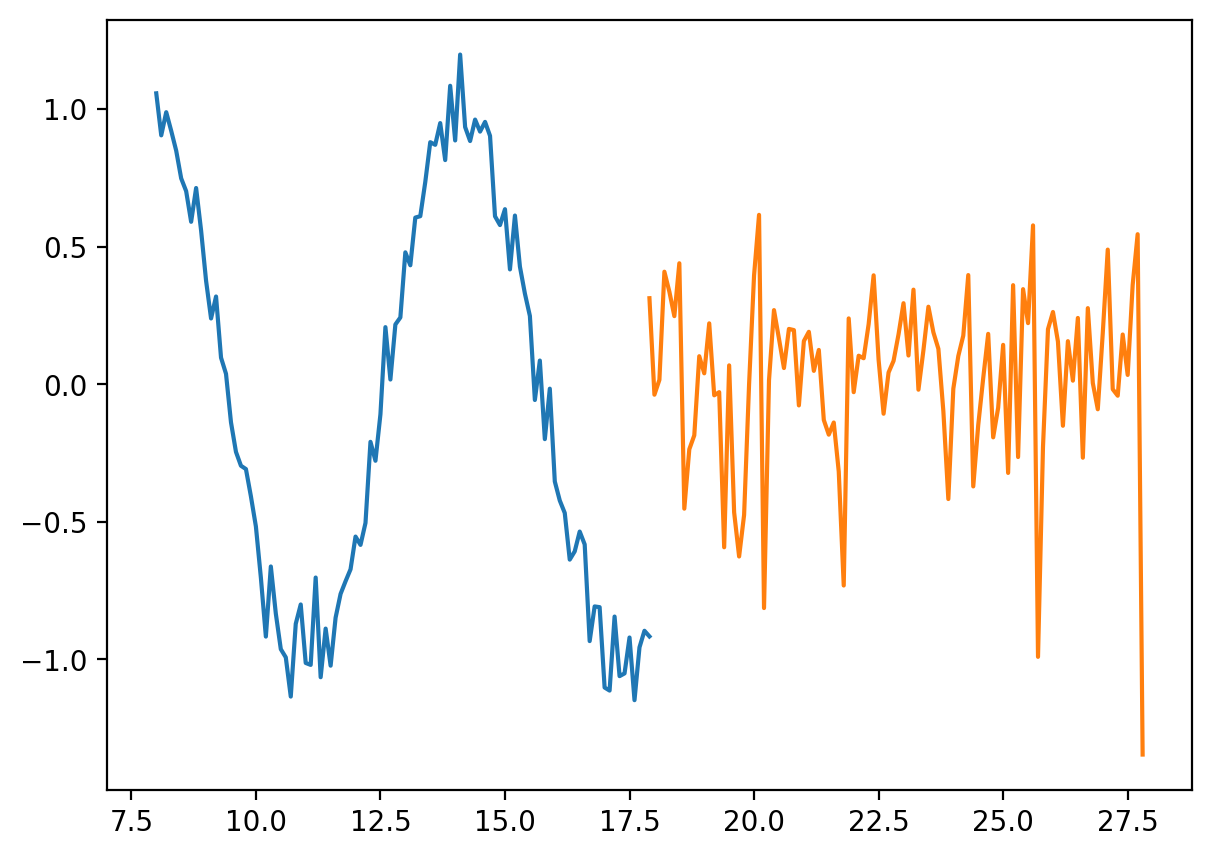

Epoch: 2701, Loss: 0.44459620118141174


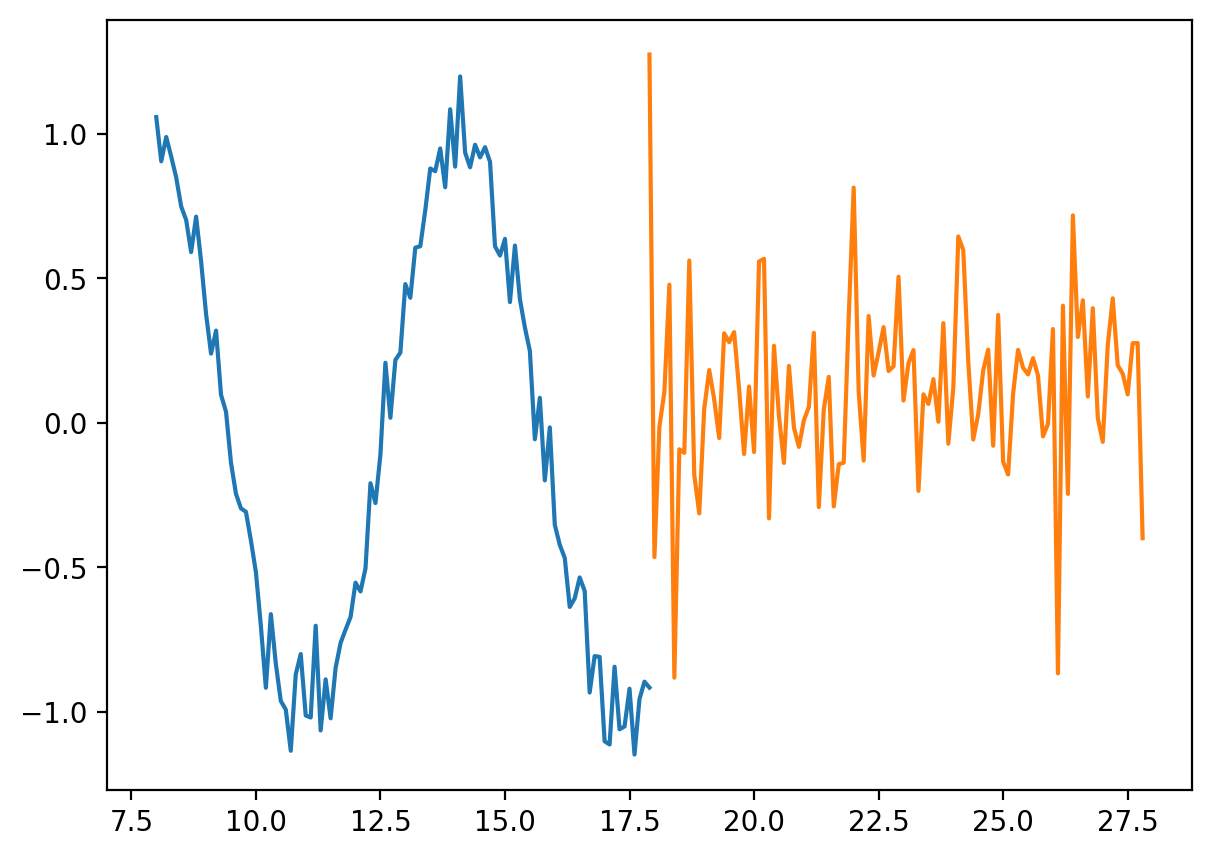

Epoch: 2801, Loss: 0.5095288753509521


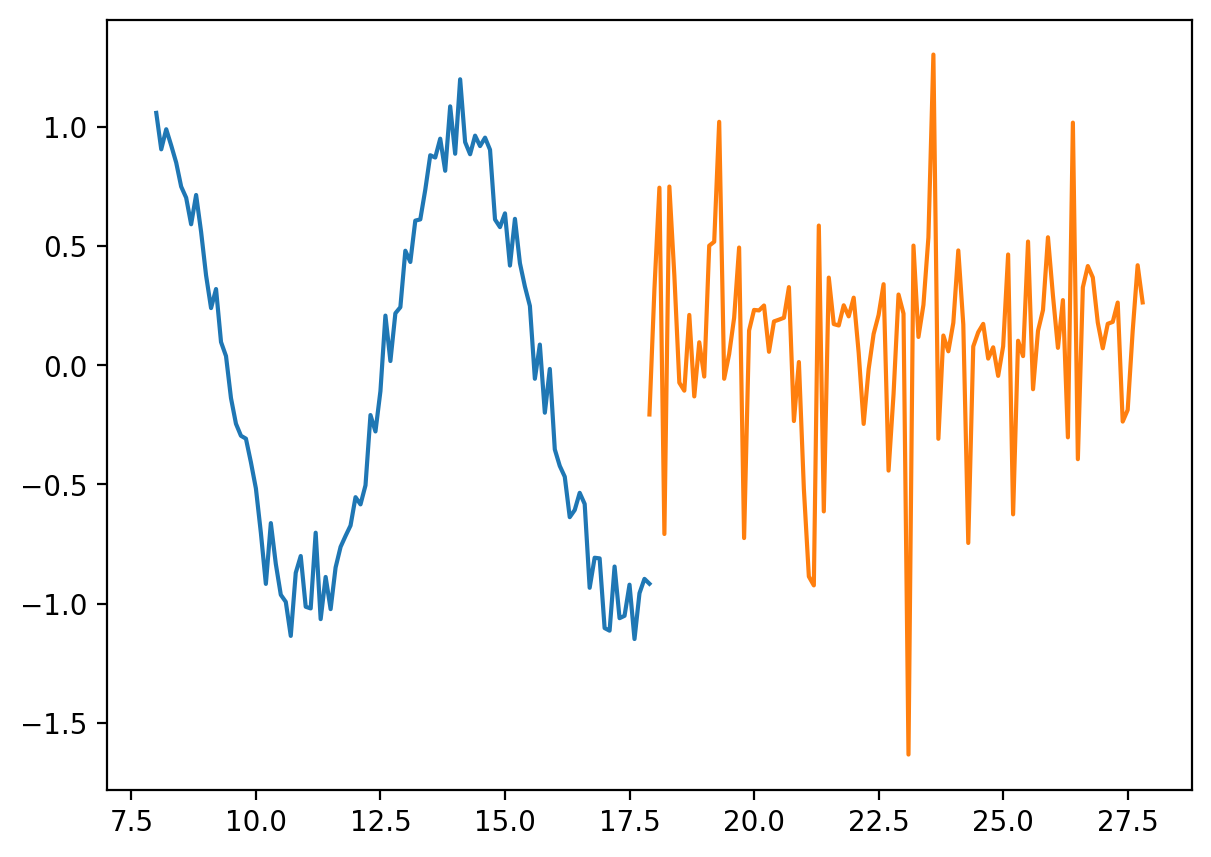

Epoch: 2901, Loss: 0.4206817150115967


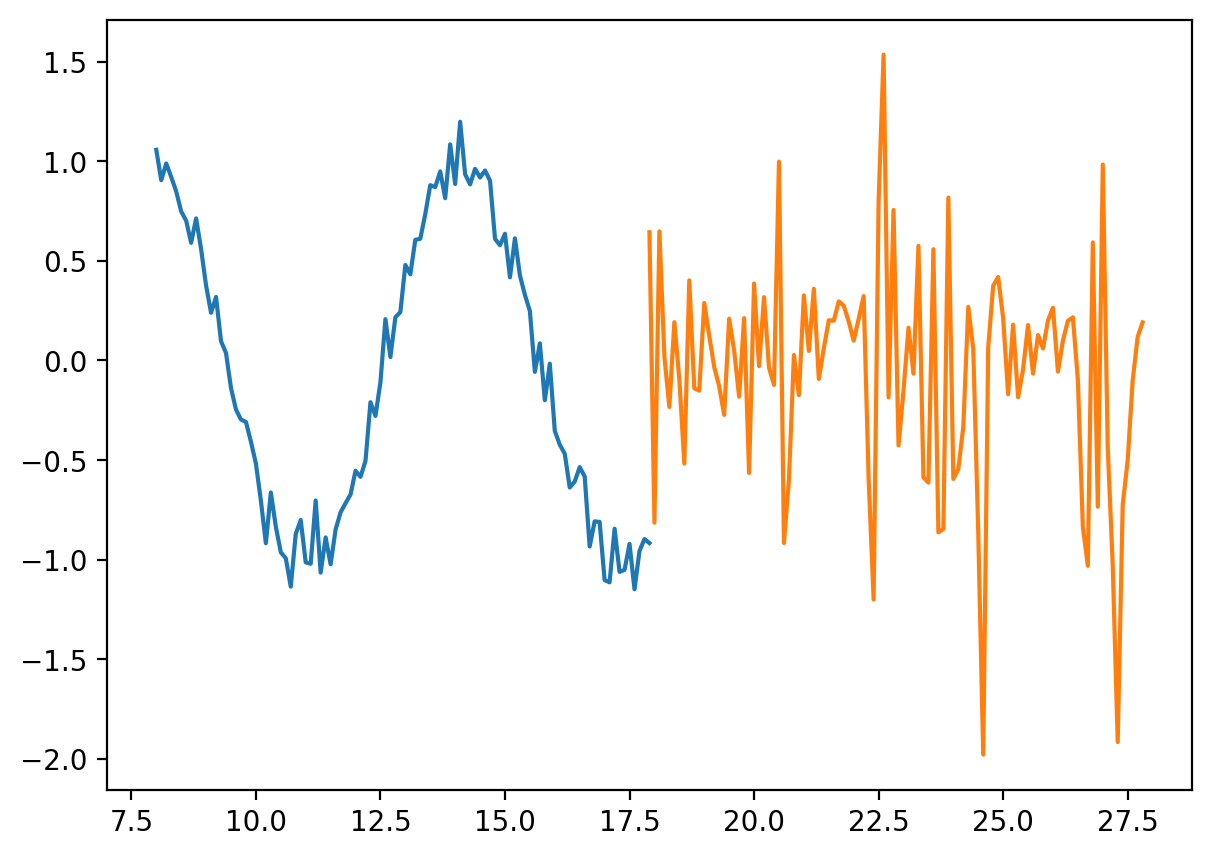

Epoch: 3001, Loss: 0.40556198358535767


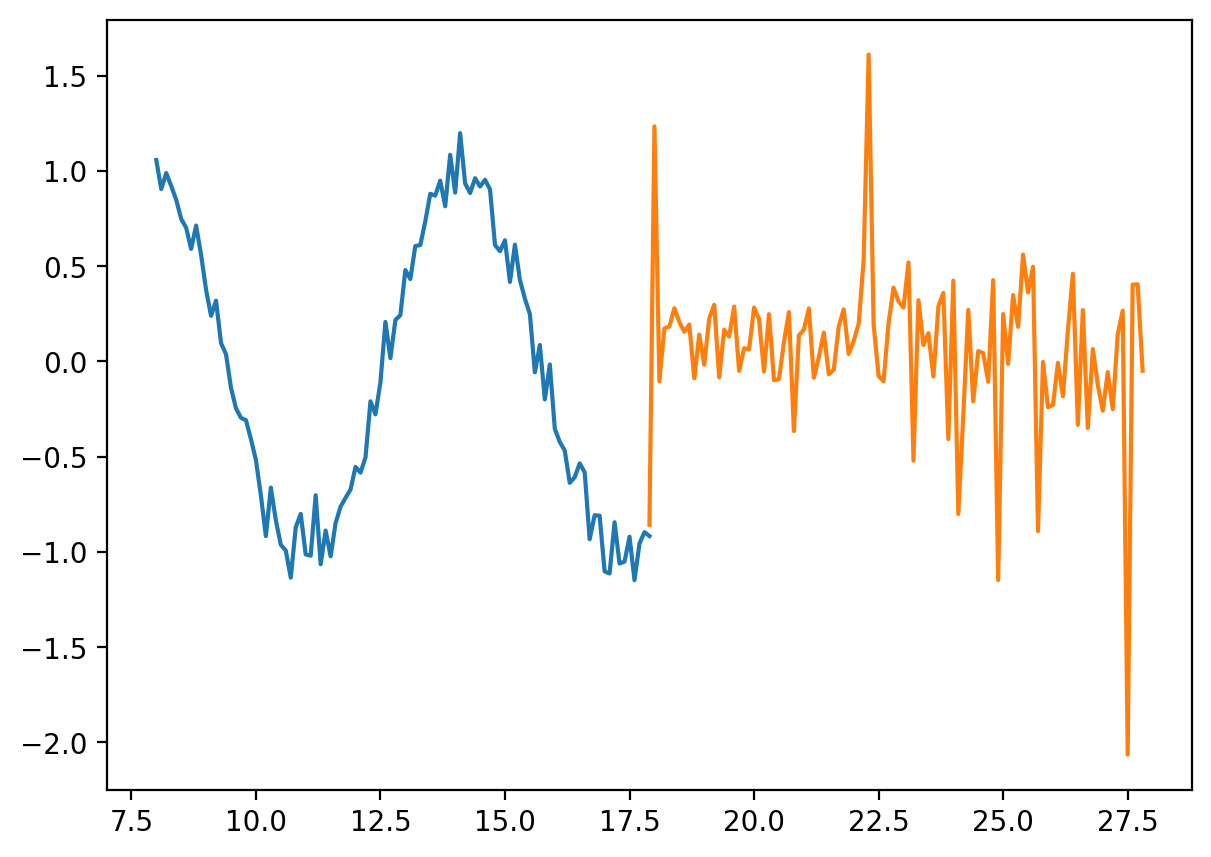

Epoch: 3101, Loss: 0.5089985728263855


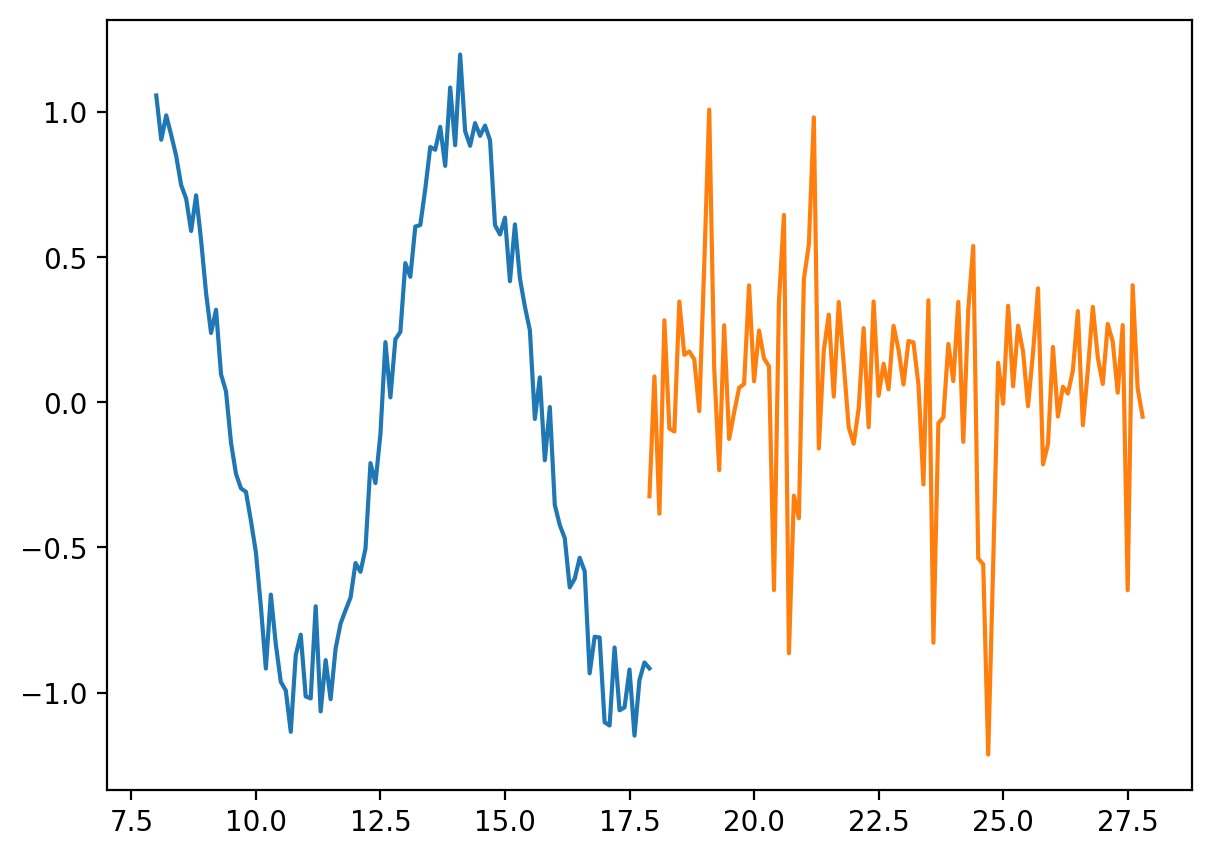

Epoch: 3201, Loss: 0.5096777081489563


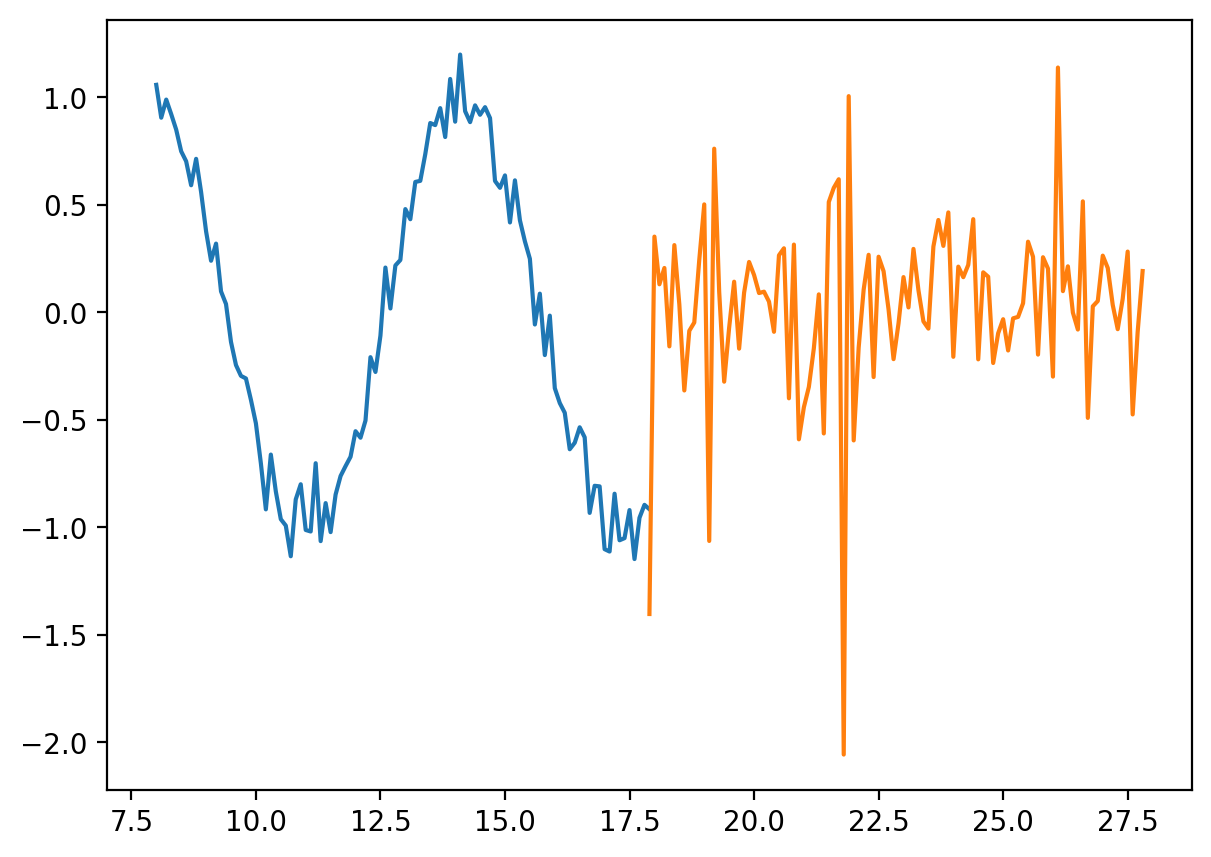

Epoch: 3301, Loss: 0.520854115486145


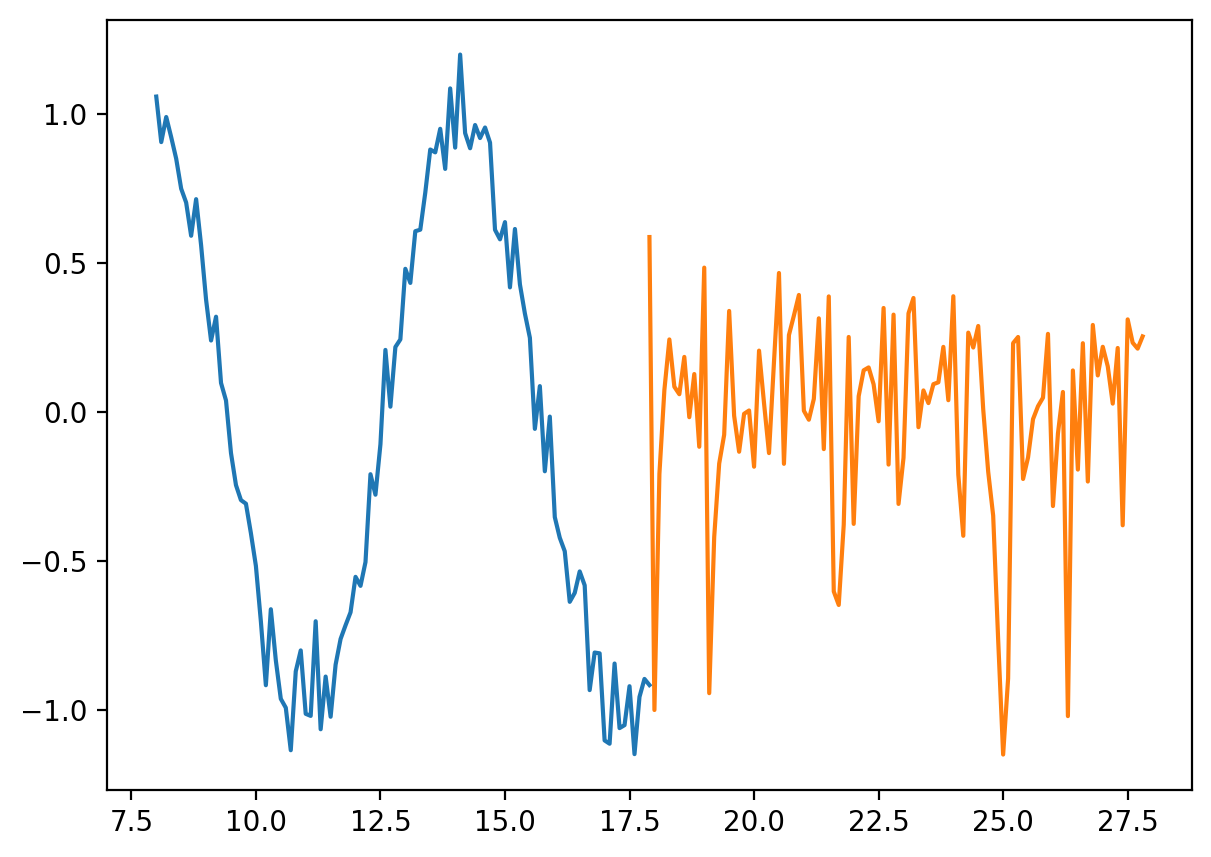

Epoch: 3401, Loss: 0.43443503975868225


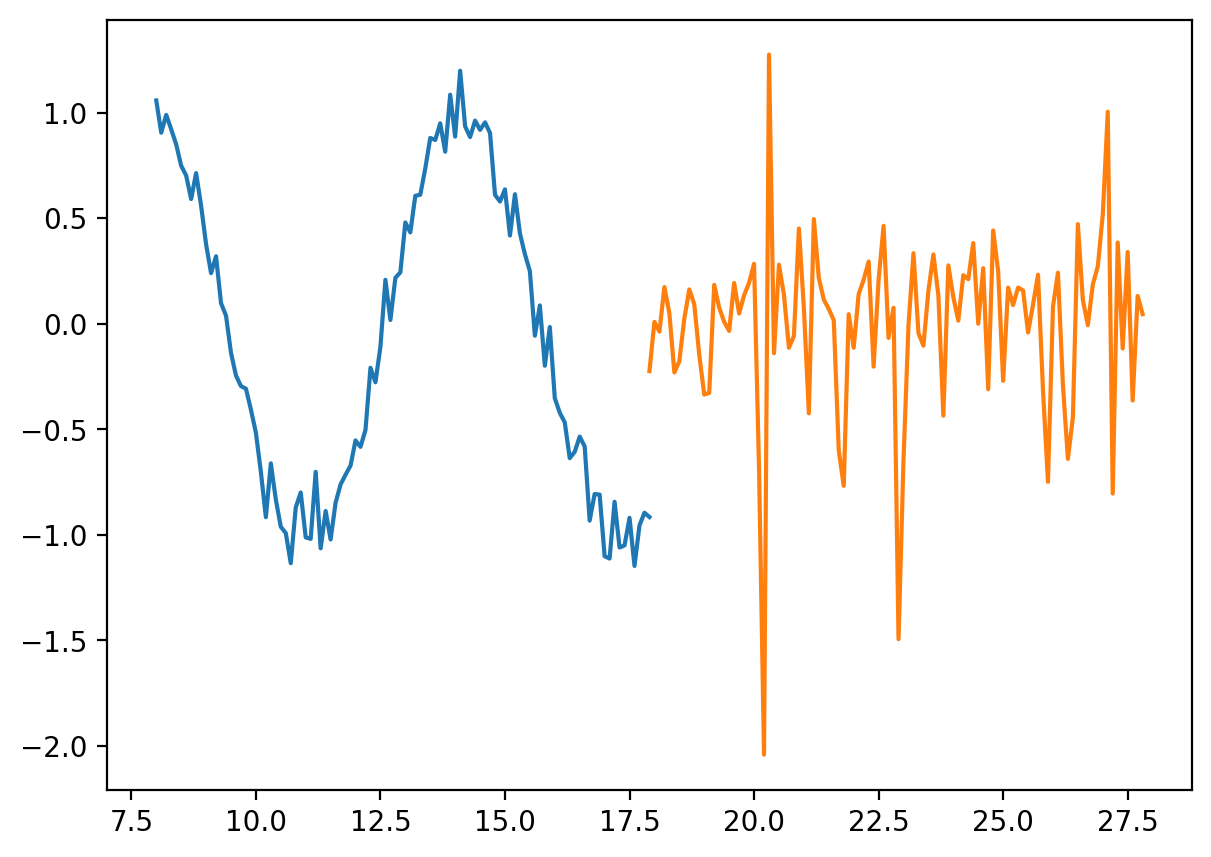

Epoch: 3501, Loss: 0.5446667075157166


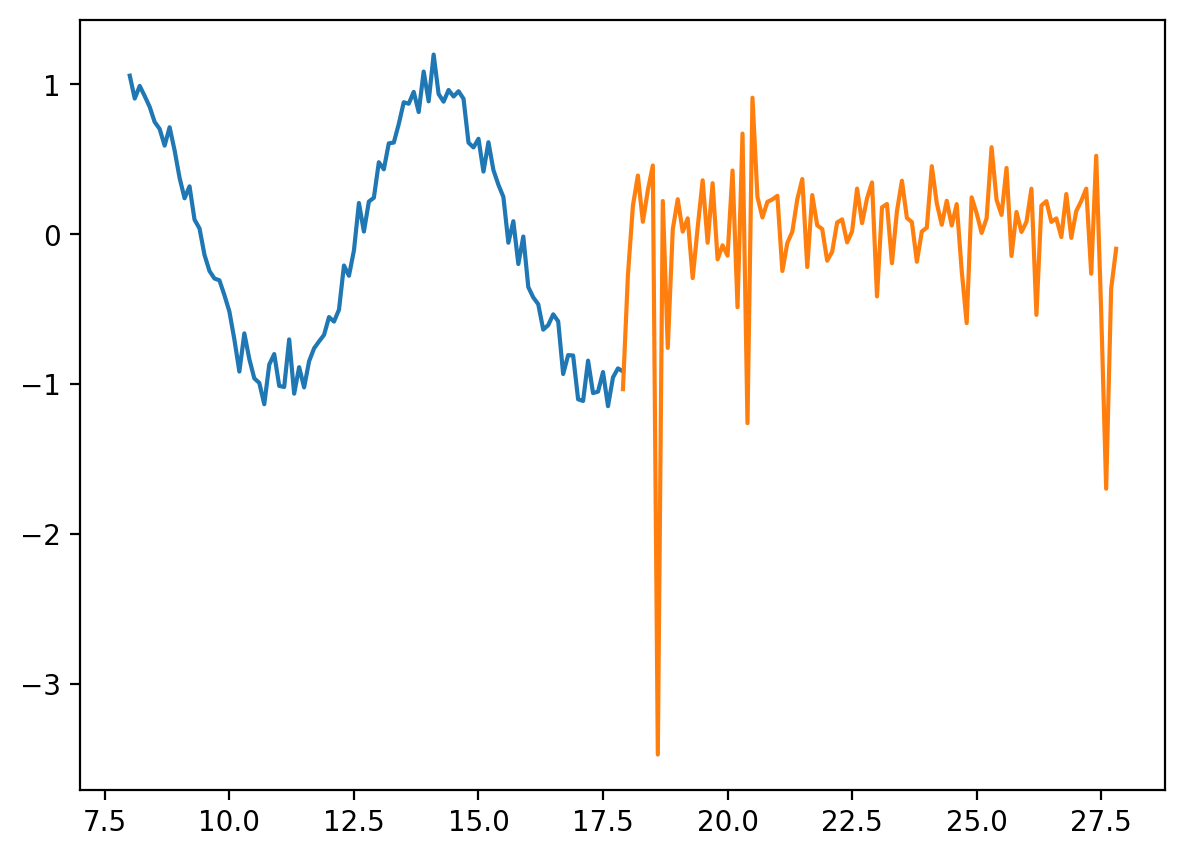

Epoch: 3601, Loss: 0.49072906374931335


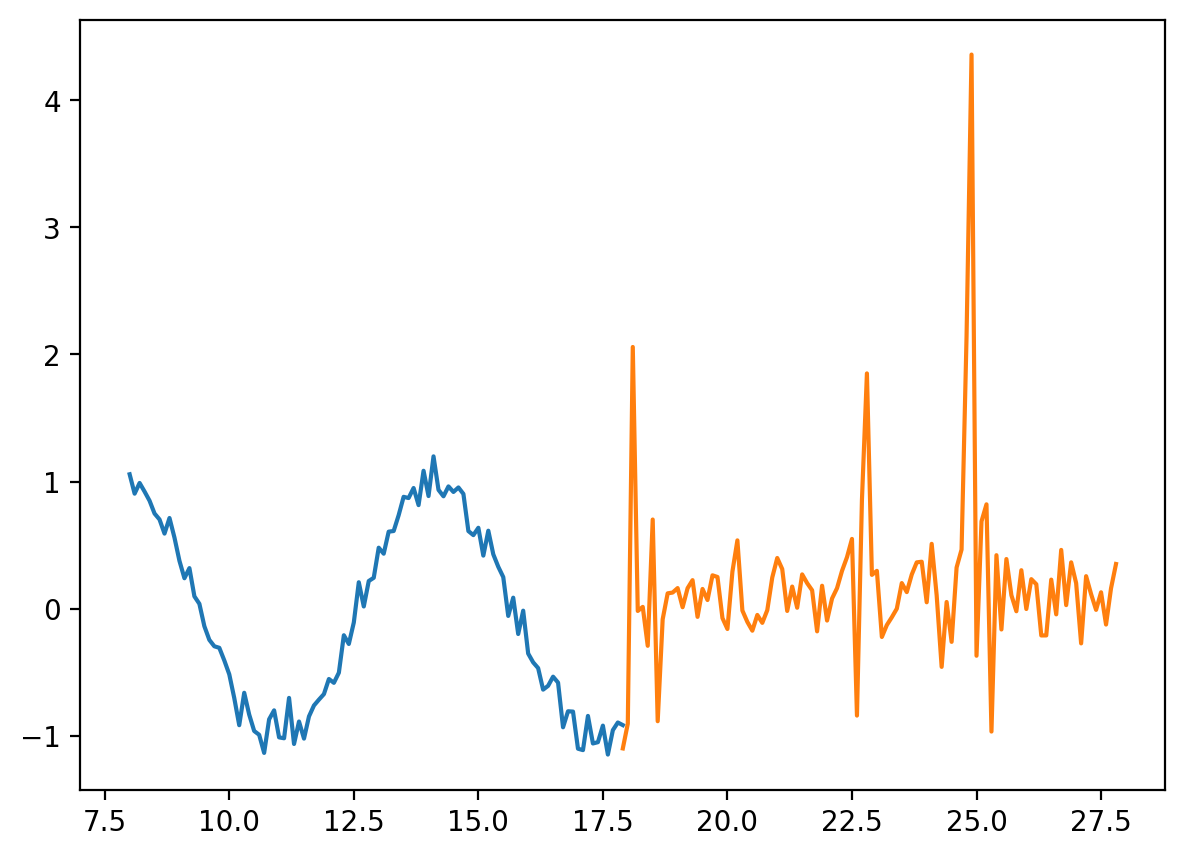

Epoch: 3701, Loss: 0.46804115176200867


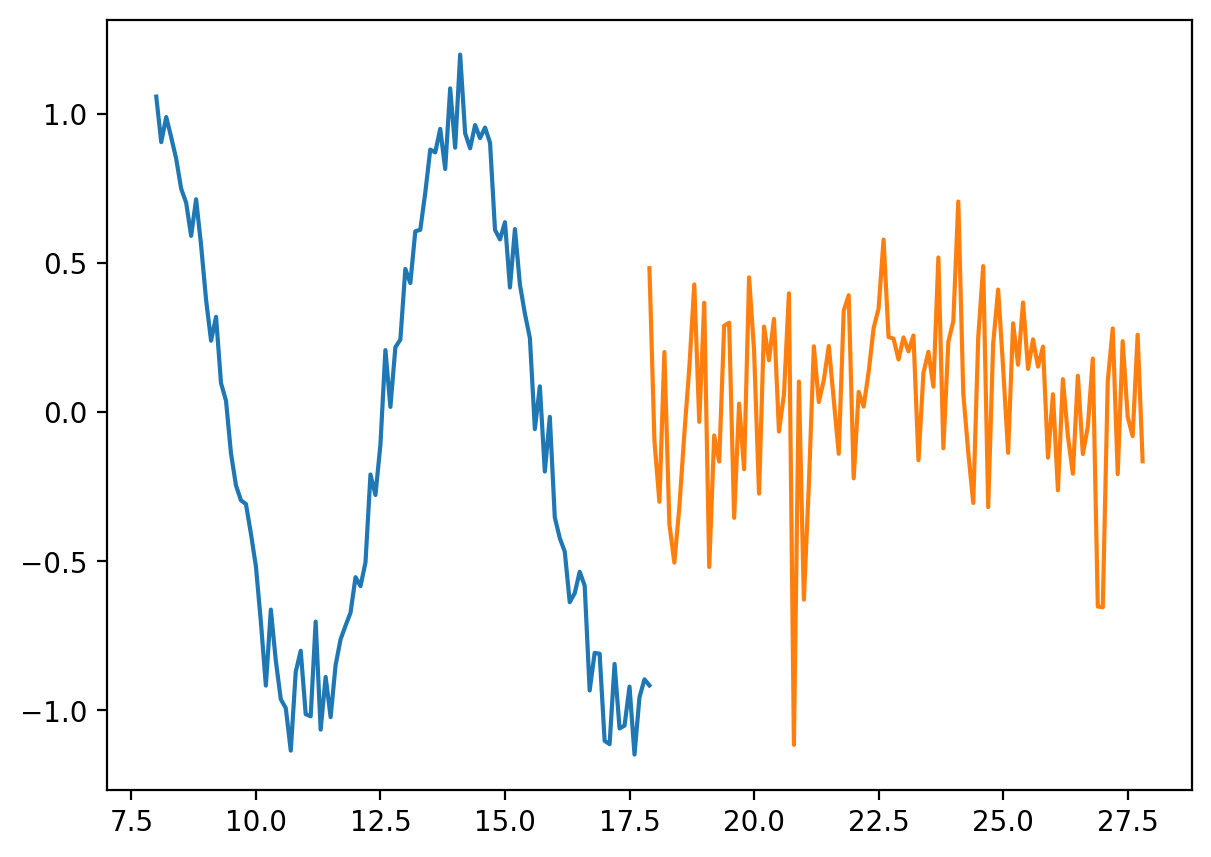

Epoch: 3801, Loss: 1.0021060705184937


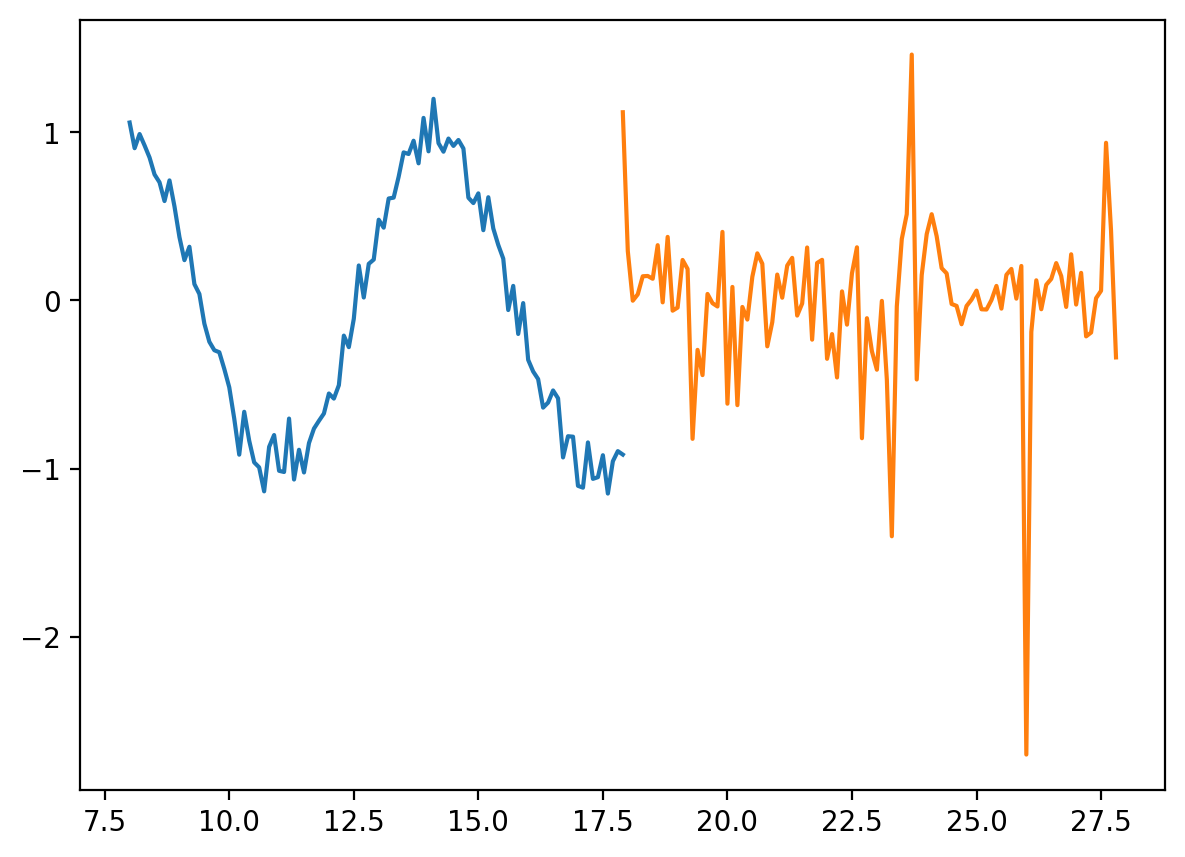

Epoch: 3901, Loss: 0.4765309989452362


KeyboardInterrupt: 

In [24]:
import importlib

importlib.reload(Transformer)

optimizer = optim.Adam(transformer.parameters(), lr=0.0001)


def Gaussian_loss(transformer_pred, y_true, epsilon=1e-8):
    # Splitting the output into mean and variance
    mean = transformer_pred[:, :, 0]
    var = (
        torch.abs(transformer_pred[:, :, 1]) + epsilon
    )  # added epsilon for numerical stability

    # Calculating the Gaussian negative log-likelihood loss
    loss = torch.mean((y_true - mean) ** 2 / var + torch.log(var))
    # loss = torch.mean((y_true - mean) ** 2)

    return loss


transformer.train()

losses = []

for epoch in range(5000):
    optimizer.zero_grad()
    output = transformer(y_train)
    loss = Gaussian_loss(output, y_true)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        sequence_length = 100

        prediction = transformer.generate(y_train[0].unsqueeze(0), sequence_length)

        plt.figure(figsize=(7, 5))
        plt.plot(times[0], y_train[0])
        T = torch.max(times[0]).numpy() - torch.min(times[0]).numpy()
        plt.plot(
            np.linspace(0, T, sequence_length) + torch.max(times[0]).numpy(),
            prediction.squeeze().detach().numpy(),
        )
        plt.show()

        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

plt.loglog(losses)

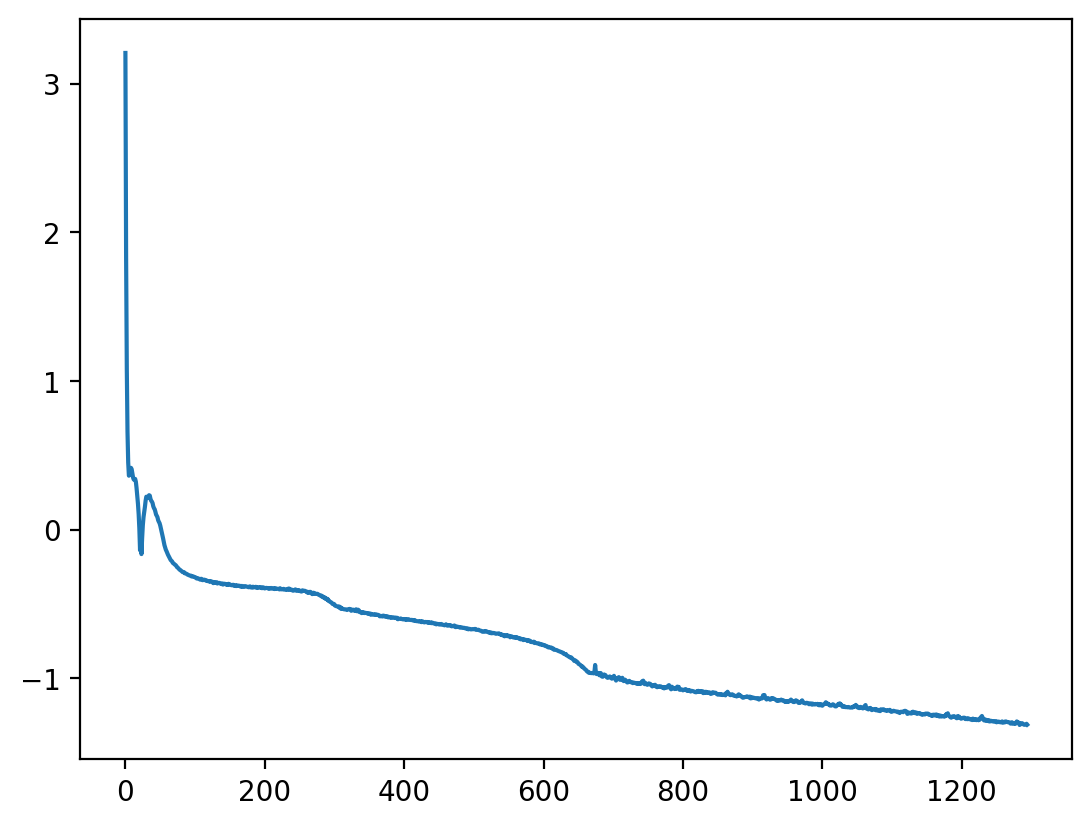

In [8]:
plt.plot(losses)

In [ ]:
print(transformer(y_train[0].unsqueeze(0))[:, :, 1])
print(torch.abs(transformer(y_train[0].unsqueeze(0))[:, :, 1]))
# print(transformer(y_train[1].unsqueeze(0))[:, :, 0])
# print(transformer(y_train[5].unsqueeze(0))[:, :, 0])

tensor([[ -9.6556,  45.8554,  47.8955,  35.0850,  57.9726,  -2.8643,  50.7849,
         -14.3273,  -3.2345,  36.2949,  64.4078,  -2.6824,  57.0178,  77.4394,
          78.1556,  52.2510,  78.8138,  76.4053,  65.0628,  75.9870,  79.3800,
          77.5359,  69.3152,  74.0515,  74.8369,  60.3824,  -2.9671,  45.7996,
          75.0720,  57.2097,  43.4463,  51.0166,  52.1162,  47.2479,  43.1508,
          41.2317,  34.9087,  -1.5851,  18.7099,  34.2824,  33.4996,  -0.7497,
          65.1554,  37.4001,  40.8269,  35.6254,  40.7316,  18.4409,  73.5046,
          63.8281,  46.0207,  48.2283,  66.0287,  73.1468,  40.1276,  66.0480,
          37.1243,  33.3380,  41.8660,  -4.4003,  33.5224,  33.6921,  -0.8450,
          54.3070,  36.7319,  41.4281,  43.7849,  30.3969,   0.3218,  54.0241,
          41.8464,  60.1987,  61.5675,  47.1747, -11.2340,  64.5473,  69.0005,
         -15.9507,  70.1978,  73.9114,  41.5225,  68.0688,  71.2776,  67.7579,
          57.7513,  63.7005,  68.4206,  50.5349,  63